# Análise de Risco de Crédito - Quantum Finance

# O Desafio

A Quantum Finance poosui um modelo de risco de crédito desatualizado, que tem concedido cartões para um número muito alto de mal pagadores gerando problemas financeiros para a companhia.
Neste contexto, a HEAD de Ciência de Dados chamous os melhores talentos de sua equipe para ajudá-los na construção de um novo modelo que será utilizado antes da conecessão de cartões de crédito aos requerentes. Uma primeira análise feita no dataser mostrou que será necessário despender grande esforço de Feature Engineering antes do desenvolvimento. 
O desafio será realizar melhorias no dataset baseadas nas melhores práticas de Feature Engineering para que , num momento posterior, seja feito o desenvolvimento do modelo.

# Configuração e dependências

É necessário possuir instaladas as dependências abaixo listadas:
- matplotlib
- sweetviz
- pandas
- numpy
- seaborn

## Importando os bibliotecas

In [4]:
import matplotlib.pyplot as plt
import sweetviz as sv
import math
import pandas as pd
import datetime
import numpy as np
import seaborn as sns

# Formata a impressao dos graficos
%matplotlib inline

# O Data Set

## Importandos o DataSet

In [5]:
cols=['ID_CLIENTE','TIPO_FUNCIONARIO','DIA_PAGAMENTO','TIPO_ENVIO_APLICACAO', 'QUANT_CARTOES_ADICIONAIS', 'TIPO_ENDERECO_POSTAL', 'SEXO', 'ESTADO_CIVIL', 'QUANT_DEPENDENTES', 'NIVEL_EDUCACIONAL' ,'ESTADO_NASCIMENTO',
      'CIDADE_NASCIMENTO', 'NACIONALIDADE','ESTADO_RESIDENCIAL','CIDADE_RESIDENCIAL','BAIRRO_RESIDENCIAL', 'FLAG_TELEFONE_RESIDENCIAL', 'CODIGO_AREA_TELEFONE_RESIDENCIAL', 'TIPO_RESIDENCIA', 'MESES_RESIDENCIA', 'FLAG_TELEFONE_MOVEL',
      'FLAG_EMAIL', 'RENDA_PESSOAL_MENSAL', 'OUTRAS_RENDAS' ,'FLAG_VISA', 'FLAG_MASTERCARD', 'FLAG_DINERS', 'FLAG_AMERICAN_EXPRESS', 'FLAG_OUTROS_CARTOES', 'QUANT_CONTAS_BANCARIAS', 'QUANT_CONTAS_BANCARIAS_ESPECIAIS', 'VALOR_PATRIMONIO_PESSOAL',
      'QUANT_CARROS', 'EMPRESA', 'ESTADO_PROFISSIONAL', 'CIDADE_PROFISSIONAL', 'BAIRRO_PROFISSIONAL', 'FLAG_TELEFONE_PROFISSIONAL', 'CODIGO_AREA_TELEFONE_PROFISSIONAL', 'MESES_NO_TRABALHO', 'CODIGO_PROFISSAO', 'TIPO_OCUPACAO',
      'CODIGO_PROFISSAO_CONJUGE', 'NIVEL_EDUCACIONAL_CONJUGE', 'FLAG_DOCUMENTO_RESIDENCIAL', 'FLAG_RG', 'FLAG_CPF', 'FLAG_COMPROVANTE_RENDA', 'PRODUTO', 'FLAG_REGISTRO_ACSP', 'IDADE', 'CEP_RESIDENCIAL_3', 'CEP_PROFISSIONAL_3', 'MAU_PAGADOR'
     ]
types_dict={'CEP_RESIDENCIAL_3':int, 'CEP_PROFISSIONAL_3':int}
dados_brutos=pd.read_csv('dataset.txt',encoding = "ISO-8859-1",sep="\t", names=cols, low_memory=False)
dados_brutos.head()

,ID_CLIENTE,TIPO_FUNCIONARIO,DIA_PAGAMENTO,TIPO_ENVIO_APLICACAO,QUANT_CARTOES_ADICIONAIS,TIPO_ENDERECO_POSTAL,SEXO,ESTADO_CIVIL,QUANT_DEPENDENTES,NIVEL_EDUCACIONAL,...,FLAG_DOCUMENTO_RESIDENCIAL,FLAG_RG,FLAG_CPF,FLAG_COMPROVANTE_RENDA,PRODUTO,FLAG_REGISTRO_ACSP,IDADE,CEP_RESIDENCIAL_3,CEP_PROFISSIONAL_3,MAU_PAGADOR
0,1,C,5,Web,0,1,F,6,1,0,...,0,0,0,0,1,N,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,0,...,0,0,0,0,1,N,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,0,...,0,0,0,0,1,N,48,235,235,1


## Descrição do DataSet

Possuimos Um data set com 50 mil entradas e 54 features, de acordo com o [dicionário](descritivo_características.xlsx).

Onde queremos prever a variável MAU_PAGADOR onde 1 é mau pagador e 0 é bom pagador

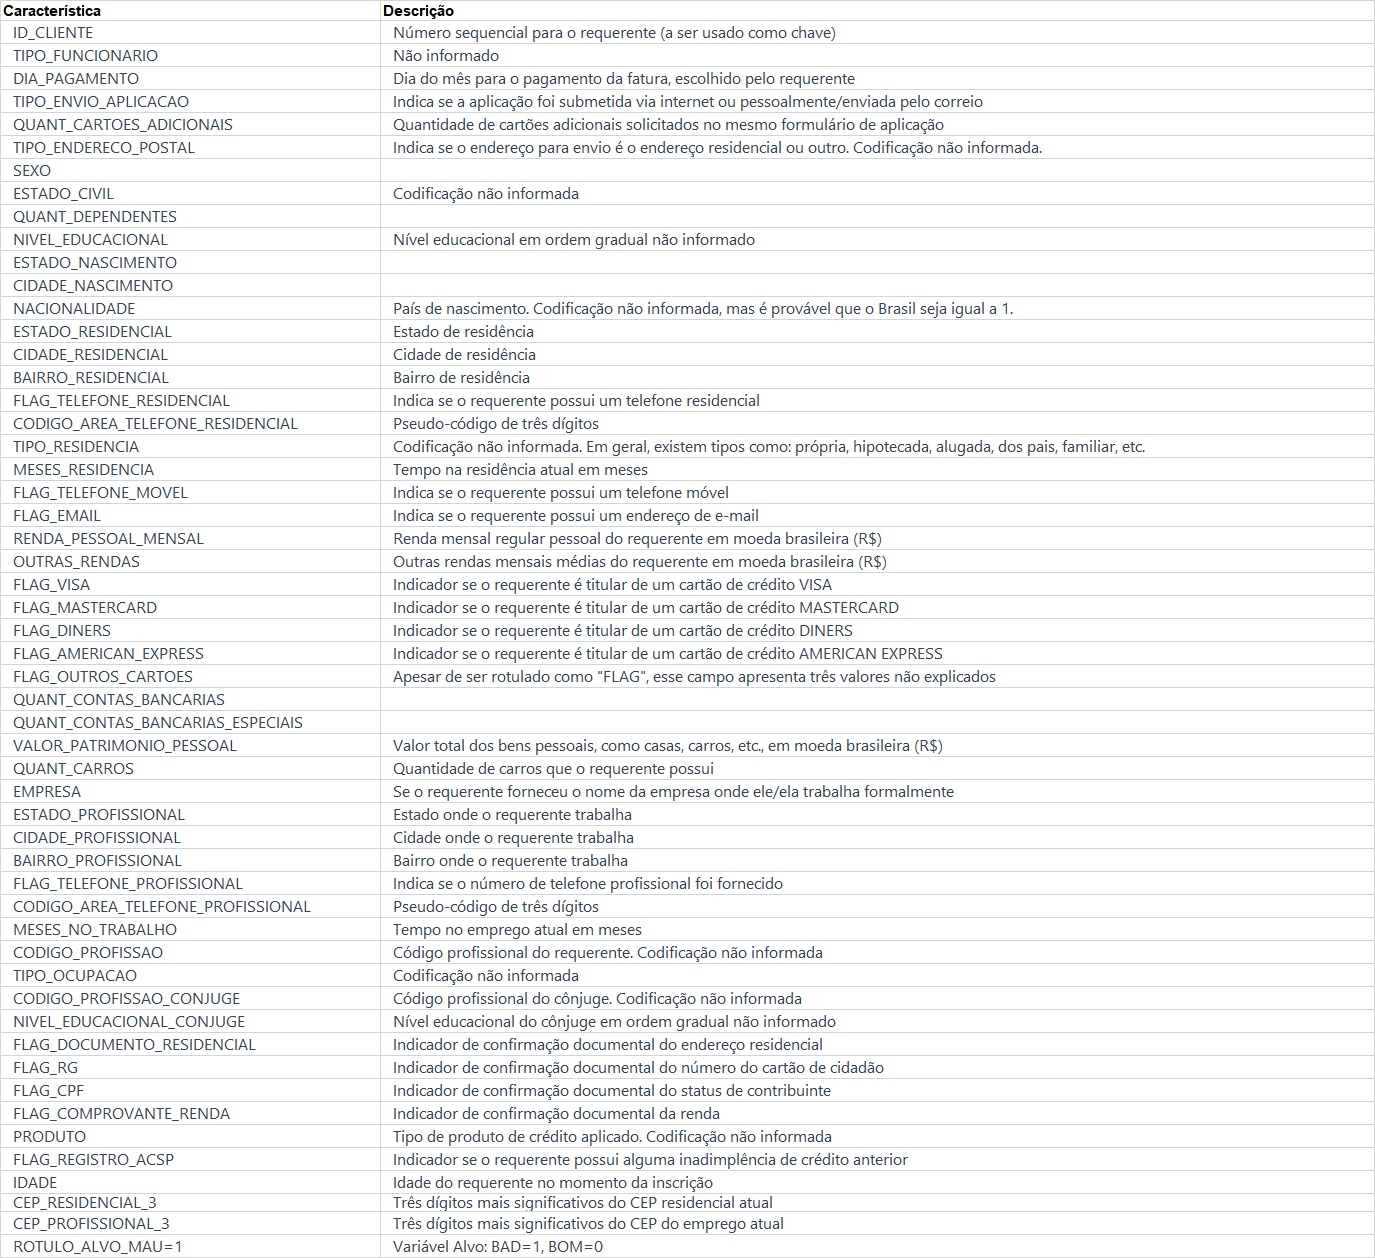!

In [6]:
dados_brutos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 54 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ID_CLIENTE                         50000 non-null  int64  
 1   TIPO_FUNCIONARIO                   50000 non-null  object 
 2   DIA_PAGAMENTO                      50000 non-null  int64  
 3   TIPO_ENVIO_APLICACAO               50000 non-null  object 
 4   QUANT_CARTOES_ADICIONAIS           50000 non-null  int64  
 5   TIPO_ENDERECO_POSTAL               50000 non-null  int64  
 6   SEXO                               50000 non-null  object 
 7   ESTADO_CIVIL                       50000 non-null  int64  
 8   QUANT_DEPENDENTES                  50000 non-null  int64  
 9   NIVEL_EDUCACIONAL                  50000 non-null  int64  
 10  ESTADO_NASCIMENTO                  50000 non-null  object 
 11  CIDADE_NASCIMENTO                  50000 non-null  obj

# Preparando o Data Set
Precisamos configurar os tipos corretos para cada coluna. Substitiur os valores inválidos de maneira padronizada. Por exemplo coluna CEP_RESIDENCIAL_3 está como string(object) e possui valores não numéricos como  '#DIV/0!'

## Copiando informações, criando listas e funções necessárioas

In [7]:
#copiando dados
dados_ajustados=dados_brutos.copy()

#Lista de features desnecessárias
features_to_drop=[]

#Função que une duas lista eliminando réplicas
def Union(lst1, lst2):
    final_list = list(set(lst1) | set(lst2))
    return final_list


#Função que transforma o tipo de uma feature e retorna um dicionario de erros
#df ->dataframe, tranformar as features da lista features para o tipo feature_type 
def find_non_numeric_string(df,feature_type, features):
    error_dict={}
    for feature in features:
        try:
            df[feature].astype(feature_type)
        except Exception as e: 
            error_dict[feature]=e

    return error_dict

def confusion_matrix_custom(y_test,y_pred):
    labels = [0,1]
    label_names = ['BP', 'MP']
    
    cm = confusion_matrix( y_test, y_pred, labels = labels, normalize='true')
    disp = ConfusionMatrixDisplay(cm, display_labels = label_names)
    return disp

In [8]:
# Use pd.to_numeric to attempt to convert 'CEP_RESIDENCIAL_3' column to numeric values
numeric_mask = pd.to_numeric(dados_ajustados['CEP_RESIDENCIAL_3'], errors='coerce').isna()

# Use the numeric_mask to filter rows where 'a' is not numeric
non_numeric_rows = dados_ajustados[['CEP_RESIDENCIAL_3']][numeric_mask]

# Display the non-numeric rows
print(non_numeric_rows)

      CEP_RESIDENCIAL_3
48923           #DIV/0!


In [9]:
# Use pd.to_numeric to attempt to convert 'a' column to numeric values
numeric_mask = pd.to_numeric(dados_ajustados['CEP_RESIDENCIAL_3'], errors='coerce').isna()

# Use the numeric_mask to filter rows where 'a' is not numeric
non_numeric_rows = dados_ajustados[['CEP_RESIDENCIAL_3']][numeric_mask]

# Display the non-numeric rows
print(non_numeric_rows)

      CEP_RESIDENCIAL_3
48923           #DIV/0!


## Configurando tipo bool

Dados do tipo boolean

In [10]:
boolean_features=['FLAG_TELEFONE_RESIDENCIAL','FLAG_EMAIL','FLAG_TELEFONE_MOVEL','FLAG_VISA','FLAG_MASTERCARD','FLAG_DINERS','FLAG_AMERICAN_EXPRESS','FLAG_AMERICAN_EXPRESS','FLAG_TELEFONE_PROFISSIONAL','FLAG_TELEFONE_RESIDENCIAL', 'FLAG_DOCUMENTO_RESIDENCIAL',
                  'FLAG_RG', 'FLAG_CPF', 'FLAG_COMPROVANTE_RENDA', 'FLAG_REGISTRO_ACSP','MAU_PAGADOR', 'EMPRESA']

dados_ajustados[boolean_features]

,FLAG_TELEFONE_RESIDENCIAL,FLAG_EMAIL,FLAG_TELEFONE_MOVEL,FLAG_VISA,FLAG_MASTERCARD,FLAG_DINERS,FLAG_AMERICAN_EXPRESS,FLAG_AMERICAN_EXPRESS,FLAG_TELEFONE_PROFISSIONAL,FLAG_TELEFONE_RESIDENCIAL,FLAG_DOCUMENTO_RESIDENCIAL,FLAG_RG,FLAG_CPF,FLAG_COMPROVANTE_RENDA,FLAG_REGISTRO_ACSP,MAU_PAGADOR,EMPRESA
0,Y,1,N,1,1,0,0,0,N,Y,0,0,0,0,N,1,N
1,Y,1,N,0,0,0,0,0,N,Y,0,0,0,0,N,1,Y
2,Y,1,N,0,0,0,0,0,N,Y,0,0,0,0,N,0,N
3,N,1,N,0,0,0,0,0,N,N,0,0,0,0,N,0,N
4,Y,1,N,0,0,0,0,0,N,Y,0,0,0,0,N,1,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,Y,1,N,0,0,0,0,0,N,Y,0,0,0,0,N,1,N
49996,Y,1,N,0,0,0,0,0,N,Y,0,0,0,0,N,0,N
49997,Y,1,N,0,0,0,0,0,Y,Y,0,0,0,0,N,0,Y
49998,Y,1,N,0,0,0,0,0,Y,Y,0,0,0,0,N,1,Y


Tipos de chave
Features ['FLAG_TELEFONE_MOVEL','FLAG_RG','FLAG_CPF','FLAG_CPF','FLAG_CPF','FLAG_REGISTRO_ACSP'] não tem informações relevantes pois tem apenas uma categoria

In [11]:
#Adicionando features desnecessárias a lista
features_to_drop=Union(features_to_drop, ['FLAG_TELEFONE_MOVEL','FLAG_RG','FLAG_CPF','FLAG_CPF','FLAG_CPF','FLAG_REGISTRO_ACSP'])

In [12]:
for feature in boolean_features:
    print(f'valores unicos de {feature}= {dados_ajustados[feature].unique()}')

valores unicos de FLAG_TELEFONE_RESIDENCIAL= ['Y' 'N']
valores unicos de FLAG_EMAIL= [1 0]
valores unicos de FLAG_TELEFONE_MOVEL= ['N']
valores unicos de FLAG_VISA= [1 0]
valores unicos de FLAG_MASTERCARD= [1 0]
valores unicos de FLAG_DINERS= [0 1]
valores unicos de FLAG_AMERICAN_EXPRESS= [0 1]
valores unicos de FLAG_AMERICAN_EXPRESS= [0 1]
valores unicos de FLAG_TELEFONE_PROFISSIONAL= ['N' 'Y']
valores unicos de FLAG_TELEFONE_RESIDENCIAL= ['Y' 'N']
valores unicos de FLAG_DOCUMENTO_RESIDENCIAL= [0]
valores unicos de FLAG_RG= [0]
valores unicos de FLAG_CPF= [0]
valores unicos de FLAG_COMPROVANTE_RENDA= [0]
valores unicos de FLAG_REGISTRO_ACSP= ['N']
valores unicos de MAU_PAGADOR= [1 0]
valores unicos de EMPRESA= ['N' 'Y']


### Transformando Y/N e 1/0 em True/False

In [13]:
transformation_dict={'Y':True,'N':False, 1:True, 0:False}

for feature in boolean_features:
    dados_ajustados[feature].replace(transformation_dict,inplace=True)
    
dados_ajustados[boolean_features]

,FLAG_TELEFONE_RESIDENCIAL,FLAG_EMAIL,FLAG_TELEFONE_MOVEL,FLAG_VISA,FLAG_MASTERCARD,FLAG_DINERS,FLAG_AMERICAN_EXPRESS,FLAG_AMERICAN_EXPRESS,FLAG_TELEFONE_PROFISSIONAL,FLAG_TELEFONE_RESIDENCIAL,FLAG_DOCUMENTO_RESIDENCIAL,FLAG_RG,FLAG_CPF,FLAG_COMPROVANTE_RENDA,FLAG_REGISTRO_ACSP,MAU_PAGADOR,EMPRESA
0,True,True,False,True,True,False,False,False,False,True,False,False,False,False,False,True,False
1,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True
2,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False
49996,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
49997,True,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True
49998,True,True,False,False,False,False,False,False,True,True,False,False,False,False,False,True,True


Listando Novas Chaves

In [14]:
for feature in boolean_features:
    print(f'valores unicos de {feature}= {dados_ajustados[feature].unique()}')

valores unicos de FLAG_TELEFONE_RESIDENCIAL= [ True False]
valores unicos de FLAG_EMAIL= [ True False]
valores unicos de FLAG_TELEFONE_MOVEL= [False]
valores unicos de FLAG_VISA= [ True False]
valores unicos de FLAG_MASTERCARD= [ True False]
valores unicos de FLAG_DINERS= [False  True]
valores unicos de FLAG_AMERICAN_EXPRESS= [False  True]
valores unicos de FLAG_AMERICAN_EXPRESS= [False  True]
valores unicos de FLAG_TELEFONE_PROFISSIONAL= [False  True]
valores unicos de FLAG_TELEFONE_RESIDENCIAL= [ True False]
valores unicos de FLAG_DOCUMENTO_RESIDENCIAL= [False]
valores unicos de FLAG_RG= [False]
valores unicos de FLAG_CPF= [False]
valores unicos de FLAG_COMPROVANTE_RENDA= [False]
valores unicos de FLAG_REGISTRO_ACSP= [False]
valores unicos de MAU_PAGADOR= [ True False]
valores unicos de EMPRESA= [False  True]


Visualizando Dados Bool

In [15]:
dados_ajustados[boolean_features].head()

,FLAG_TELEFONE_RESIDENCIAL,FLAG_EMAIL,FLAG_TELEFONE_MOVEL,FLAG_VISA,FLAG_MASTERCARD,FLAG_DINERS,FLAG_AMERICAN_EXPRESS,FLAG_AMERICAN_EXPRESS,FLAG_TELEFONE_PROFISSIONAL,FLAG_TELEFONE_RESIDENCIAL,FLAG_DOCUMENTO_RESIDENCIAL,FLAG_RG,FLAG_CPF,FLAG_COMPROVANTE_RENDA,FLAG_REGISTRO_ACSP,MAU_PAGADOR,EMPRESA
0,True,True,False,True,True,False,False,False,False,True,False,False,False,False,False,True,False
1,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True
2,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False


Visualizando info de dados Bool

In [16]:
dados_ajustados[boolean_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   FLAG_TELEFONE_RESIDENCIAL   50000 non-null  bool 
 1   FLAG_EMAIL                  50000 non-null  bool 
 2   FLAG_TELEFONE_MOVEL         50000 non-null  bool 
 3   FLAG_VISA                   50000 non-null  bool 
 4   FLAG_MASTERCARD             50000 non-null  bool 
 5   FLAG_DINERS                 50000 non-null  bool 
 6   FLAG_AMERICAN_EXPRESS       50000 non-null  bool 
 7   FLAG_AMERICAN_EXPRESS       50000 non-null  bool 
 8   FLAG_TELEFONE_PROFISSIONAL  50000 non-null  bool 
 9   FLAG_TELEFONE_RESIDENCIAL   50000 non-null  bool 
 10  FLAG_DOCUMENTO_RESIDENCIAL  50000 non-null  bool 
 11  FLAG_RG                     50000 non-null  bool 
 12  FLAG_CPF                    50000 non-null  bool 
 13  FLAG_COMPROVANTE_RENDA      50000 non-null  bool 
 14  FLAG_R

## Corrigindo Features Categóricas

### Transformando features categóricas em object

In [17]:
dados_ajustados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 54 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ID_CLIENTE                         50000 non-null  int64  
 1   TIPO_FUNCIONARIO                   50000 non-null  object 
 2   DIA_PAGAMENTO                      50000 non-null  int64  
 3   TIPO_ENVIO_APLICACAO               50000 non-null  object 
 4   QUANT_CARTOES_ADICIONAIS           50000 non-null  int64  
 5   TIPO_ENDERECO_POSTAL               50000 non-null  int64  
 6   SEXO                               50000 non-null  object 
 7   ESTADO_CIVIL                       50000 non-null  int64  
 8   QUANT_DEPENDENTES                  50000 non-null  int64  
 9   NIVEL_EDUCACIONAL                  50000 non-null  int64  
 10  ESTADO_NASCIMENTO                  50000 non-null  object 
 11  CIDADE_NASCIMENTO                  50000 non-null  obj

Transformando em object as features categóricas que estão como float ou int

In [18]:
features_to_transform=['DIA_PAGAMENTO','QUANT_CARTOES_ADICIONAIS','TIPO_ENDERECO_POSTAL','ESTADO_CIVIL','NIVEL_EDUCACIONAL','NACIONALIDADE','TIPO_RESIDENCIA','MESES_RESIDENCIA',
                       'FLAG_OUTROS_CARTOES','CODIGO_PROFISSAO','TIPO_OCUPACAO','CODIGO_PROFISSAO_CONJUGE','NIVEL_EDUCACIONAL_CONJUGE','PRODUTO','ID_CLIENTE']

In [19]:
for feature in features_to_transform:
    dados_ajustados[feature]=dados_ajustados[feature].astype(object)

In [20]:
dados_ajustados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 54 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ID_CLIENTE                         50000 non-null  object 
 1   TIPO_FUNCIONARIO                   50000 non-null  object 
 2   DIA_PAGAMENTO                      50000 non-null  object 
 3   TIPO_ENVIO_APLICACAO               50000 non-null  object 
 4   QUANT_CARTOES_ADICIONAIS           50000 non-null  object 
 5   TIPO_ENDERECO_POSTAL               50000 non-null  object 
 6   SEXO                               50000 non-null  object 
 7   ESTADO_CIVIL                       50000 non-null  object 
 8   QUANT_DEPENDENTES                  50000 non-null  int64  
 9   NIVEL_EDUCACIONAL                  50000 non-null  object 
 10  ESTADO_NASCIMENTO                  50000 non-null  object 
 11  CIDADE_NASCIMENTO                  50000 non-null  obj

## Visualizando Features Categoricas

In [21]:
object_features = dados_ajustados.select_dtypes(include=['object']).columns.tolist()

dados_ajustados[object_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   ID_CLIENTE                         50000 non-null  object
 1   TIPO_FUNCIONARIO                   50000 non-null  object
 2   DIA_PAGAMENTO                      50000 non-null  object
 3   TIPO_ENVIO_APLICACAO               50000 non-null  object
 4   QUANT_CARTOES_ADICIONAIS           50000 non-null  object
 5   TIPO_ENDERECO_POSTAL               50000 non-null  object
 6   SEXO                               50000 non-null  object
 7   ESTADO_CIVIL                       50000 non-null  object
 8   NIVEL_EDUCACIONAL                  50000 non-null  object
 9   ESTADO_NASCIMENTO                  50000 non-null  object
 10  CIDADE_NASCIMENTO                  50000 non-null  object
 11  NACIONALIDADE                      50000 non-null  object
 12  ESTA

### Visualizando Chaves por feature

In [22]:
for feature in object_features:
    print(f'valores unicos de {feature}= {dados_ajustados[feature].unique()}\n')

valores unicos de ID_CLIENTE= [1 2 3 ... 49998 49999 50000]

valores unicos de TIPO_FUNCIONARIO= ['C']

valores unicos de DIA_PAGAMENTO= [5 15 20 10 25 1]

valores unicos de TIPO_ENVIO_APLICACAO= ['Web' 'Carga' '0']

valores unicos de QUANT_CARTOES_ADICIONAIS= [0]

valores unicos de TIPO_ENDERECO_POSTAL= [1 2]

valores unicos de SEXO= ['F' 'M' 'N' ' ']

valores unicos de ESTADO_CIVIL= [6 2 1 5 3 7 4 0]

valores unicos de NIVEL_EDUCACIONAL= [0]

valores unicos de ESTADO_NASCIMENTO= ['RN' 'RJ' 'PE' 'MG' 'BA' 'SP' 'RS' 'CE' 'PA' 'PB' 'MA' ' ' 'GO' 'AC' 'MT'
 'AL' 'AP' 'TO' 'SC' 'PR' 'MS' 'DF' 'PI' 'RO' 'ES' 'AM' 'SE' 'RR' 'XX']

valores unicos de CIDADE_NASCIMENTO= ['Assu' 'rio de janeiro' 'GARANHUNS' ... 'ITRATIM' 'lobo leite'
 'PIQUET CARNEIRO CE']

valores unicos de NACIONALIDADE= [1 0 2]

valores unicos de ESTADO_RESIDENCIAL= ['RN' 'RJ' 'PE' 'MG' 'BA' 'SP' 'RS' 'CE' 'AP' 'MS' 'DF' 'PB' 'MA' 'PA'
 'GO' 'PR' 'MT' 'AL' 'ES' 'SC' 'AM' 'RO' 'PI' 'RR' 'TO' 'SE' 'AC']

valores unicos de CIDA

### Ajustando Chaves da Feature ESTADO_NASCIMENTO

ESTADO_NASCIMENTO= ['RN' 'RJ' 'PE' 'MG' 'BA' 'SP' 'RS' 'CE' 'PA' 'PB' 'MA' ' ' 'GO' 'AC' 'MT'
 'AL' 'AP' 'TO' 'SC' 'PR' 'MS' 'DF' 'PI' 'RO' 'ES' 'AM' 'SE' 'RR' 'XX']

In [23]:
trans_dict={' ':np.nan,'XX':np.nan}
dados_ajustados['ESTADO_NASCIMENTO'].replace(trans_dict,inplace=True)
dados_ajustados['ESTADO_NASCIMENTO'].unique()

array(['RN', 'RJ', 'PE', 'MG', 'BA', 'SP', 'RS', 'CE', 'PA', 'PB', 'MA',
       nan, 'GO', 'AC', 'MT', 'AL', 'AP', 'TO', 'SC', 'PR', 'MS', 'DF',
       'PI', 'RO', 'ES', 'AM', 'SE', 'RR'], dtype=object)

### Ajustando Chaves da Feature TIPO_ENVIO_APLICACAO

valores unicos de TIPO_ENVIO_APLICACAO= ['Web' 'Carga' '0']


In [24]:
trans_dict={'0':'Pessoalmente'}
dados_ajustados['TIPO_ENVIO_APLICACAO'].replace(trans_dict,inplace=True)
dados_ajustados['TIPO_ENVIO_APLICACAO'].unique()

array(['Web', 'Carga', 'Pessoalmente'], dtype=object)

### Ajustando Chaves da Feature SEXO

valores unicos de SEXO= ['F' 'M' 'N' ' ']


In [25]:
trans_dict={'N':np.nan,' ':np.nan}
dados_ajustados['SEXO'].replace(trans_dict,inplace=True)
dados_ajustados['SEXO'].unique()

array(['F', 'M', nan], dtype=object)

### Ajustando Outras Features

In [26]:
cat_features_with_problems=['CODIGO_AREA_TELEFONE_RESIDENCIAL','CODIGO_AREA_TELEFONE_PROFISSIONAL','CEP_RESIDENCIAL_3','CEP_PROFISSIONAL_3']
dados_ajustados[cat_features_with_problems].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   CODIGO_AREA_TELEFONE_RESIDENCIAL   50000 non-null  object
 1   CODIGO_AREA_TELEFONE_PROFISSIONAL  50000 non-null  object
 2   CEP_RESIDENCIAL_3                  50000 non-null  object
 3   CEP_PROFISSIONAL_3                 50000 non-null  object
dtypes: object(4)
memory usage: 1.5+ MB


Visualizando valores únicos

Encontrando erros

In [27]:
error_dict=find_non_numeric_string(dados_ajustados,int,cat_features_with_problems)
print(error_dict)

{'CODIGO_AREA_TELEFONE_RESIDENCIAL': ValueError("invalid literal for int() with base 10: ' '"), 'CODIGO_AREA_TELEFONE_PROFISSIONAL': ValueError("invalid literal for int() with base 10: ' '"), 'CEP_RESIDENCIAL_3': ValueError("invalid literal for int() with base 10: '#DIV/0!'"), 'CEP_PROFISSIONAL_3': ValueError("invalid literal for int() with base 10: '#DIV/0!'")}


Os dados categóricos sem informação vamos manter como 'invalido'

In [28]:
transformation_dict={'#DIV/0!':np.nan,' ':np.nan}
for feature in cat_features_with_problems:
        dados_ajustados[feature].replace(transformation_dict, inplace=True)

In [29]:
dados_ajustados['CEP_RESIDENCIAL_3'].astype(float).info()

<class 'pandas.core.series.Series'>
RangeIndex: 50000 entries, 0 to 49999
Series name: CEP_RESIDENCIAL_3
Non-Null Count  Dtype  
--------------  -----  
49999 non-null  float64
dtypes: float64(1)
memory usage: 390.8 KB


## Dropando Features sem informações

In [30]:
#Criando lista de features descartadas
features_drop=[]

In [31]:
n_keys={}
for feature in object_features:
    n_keys[feature]=dados_ajustados[feature].nunique()

n_keys

{'ID_CLIENTE': 50000,
 'TIPO_FUNCIONARIO': 1,
 'DIA_PAGAMENTO': 6,
 'TIPO_ENVIO_APLICACAO': 3,
 'QUANT_CARTOES_ADICIONAIS': 1,
 'TIPO_ENDERECO_POSTAL': 2,
 'SEXO': 2,
 'ESTADO_CIVIL': 8,
 'NIVEL_EDUCACIONAL': 1,
 'ESTADO_NASCIMENTO': 27,
 'CIDADE_NASCIMENTO': 9910,
 'NACIONALIDADE': 3,
 'ESTADO_RESIDENCIAL': 27,
 'CIDADE_RESIDENCIAL': 3529,
 'BAIRRO_RESIDENCIAL': 14511,
 'CODIGO_AREA_TELEFONE_RESIDENCIAL': 101,
 'TIPO_RESIDENCIA': 6,
 'MESES_RESIDENCIA': 88,
 'FLAG_OUTROS_CARTOES': 2,
 'ESTADO_PROFISSIONAL': 28,
 'CIDADE_PROFISSIONAL': 2236,
 'BAIRRO_PROFISSIONAL': 5057,
 'CODIGO_AREA_TELEFONE_PROFISSIONAL': 86,
 'CODIGO_PROFISSAO': 19,
 'TIPO_OCUPACAO': 6,
 'CODIGO_PROFISSAO_CONJUGE': 18,
 'NIVEL_EDUCACIONAL_CONJUGE': 6,
 'PRODUTO': 3,
 'CEP_RESIDENCIAL_3': 793,
 'CEP_PROFISSIONAL_3': 793}

In [32]:
n_keys={}
for feature in boolean_features:
    n_keys[feature]=dados_ajustados[feature].nunique()
    
n_keys

{'FLAG_TELEFONE_RESIDENCIAL': 2,
 'FLAG_EMAIL': 2,
 'FLAG_TELEFONE_MOVEL': 1,
 'FLAG_VISA': 2,
 'FLAG_MASTERCARD': 2,
 'FLAG_DINERS': 2,
 'FLAG_AMERICAN_EXPRESS': 2,
 'FLAG_TELEFONE_PROFISSIONAL': 2,
 'FLAG_DOCUMENTO_RESIDENCIAL': 1,
 'FLAG_RG': 1,
 'FLAG_CPF': 1,
 'FLAG_COMPROVANTE_RENDA': 1,
 'FLAG_REGISTRO_ACSP': 1,
 'MAU_PAGADOR': 2,
 'EMPRESA': 2}

As Features ['NIVEL_EDUCACIONAL','QUANT_CARTOES_ADICIONAIS','TIPO_FUNCIONARIO','FLAG_TELEFONE_MOVEL','FLAG_DOCUMENTO_RESIDENCIAL','FLAG_RG','FLAG_CPF', 'FLAG_COMPROVANTE_RENDA', 'FLAG_REGISTRO_ACSP'] só tem uma categoria então vamo deixá-las de lado.



In [33]:
drop=['NIVEL_EDUCACIONAL','QUANT_CARTOES_ADICIONAIS','TIPO_FUNCIONARIO','FLAG_TELEFONE_MOVEL','FLAG_DOCUMENTO_RESIDENCIAL','FLAG_RG','FLAG_CPF', 'FLAG_COMPROVANTE_RENDA', 'FLAG_REGISTRO_ACSP']
dados_ajustados.drop(columns=drop, inplace=True)

features_drop=Union(features_drop,drop)

As Features 'CIDADE_NASCIMENTO': 9910, 'CIDADE_RESIDENCIAL','BAIRRO_RESIDENCIAL','CIDADE_PROFISSIONAL',BAIRRO_PROFISSIONAL','CODIGO_AREA_TELEFONE_PROFISSIONAL', 'CODIGO_AREA_TELEFONE_RESIDENCIAL', 'CEP_RESIDENCIAL_3', 'CEP_PROFISSIONAL_3' possuem muitas categorias e serão desconsideradas

In [34]:
drop=['CIDADE_NASCIMENTO', 'CIDADE_RESIDENCIAL','BAIRRO_RESIDENCIAL','CIDADE_PROFISSIONAL','BAIRRO_PROFISSIONAL','CODIGO_AREA_TELEFONE_PROFISSIONAL', 
      'CODIGO_AREA_TELEFONE_RESIDENCIAL', 'CEP_RESIDENCIAL_3', 'CEP_PROFISSIONAL_3','ID_CLIENTE',]
dados_ajustados.drop(columns=drop, inplace=True)

features_drop=Union(features_drop,drop)

Agora podemos ver o Número de Entradas com dados faltantes

In [35]:
dados_ajustados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   DIA_PAGAMENTO                     50000 non-null  object 
 1   TIPO_ENVIO_APLICACAO              50000 non-null  object 
 2   TIPO_ENDERECO_POSTAL              50000 non-null  object 
 3   SEXO                              49935 non-null  object 
 4   ESTADO_CIVIL                      50000 non-null  object 
 5   QUANT_DEPENDENTES                 50000 non-null  int64  
 6   ESTADO_NASCIMENTO                 47935 non-null  object 
 7   NACIONALIDADE                     50000 non-null  object 
 8   ESTADO_RESIDENCIAL                50000 non-null  object 
 9   FLAG_TELEFONE_RESIDENCIAL         50000 non-null  bool   
 10  TIPO_RESIDENCIA                   48651 non-null  object 
 11  MESES_RESIDENCIA                  46223 non-null  object 
 12  FLAG

# Avaliação Inicial
Definição do K ótimo e do Recall base para comparação da base somente com variáveis numéricas

## Definição de K ótimo  

### Separando dados em X_train, X_test,y_train,y_test somente com variáveis numéricas e booleanas

In [37]:
from sklearn.model_selection import train_test_split

object_features = dados_ajustados.select_dtypes(include=['object']).columns.tolist()

X=dados_ajustados.drop('MAU_PAGADOR', axis=1)
X=X.drop(object_features,axis=1)
y=dados_ajustados['MAU_PAGADOR']

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   QUANT_DEPENDENTES                 50000 non-null  int64  
 1   FLAG_TELEFONE_RESIDENCIAL         50000 non-null  bool   
 2   FLAG_EMAIL                        50000 non-null  bool   
 3   RENDA_PESSOAL_MENSAL              50000 non-null  float64
 4   OUTRAS_RENDAS                     50000 non-null  float64
 5   FLAG_VISA                         50000 non-null  bool   
 6   FLAG_MASTERCARD                   50000 non-null  bool   
 7   FLAG_DINERS                       50000 non-null  bool   
 8   FLAG_AMERICAN_EXPRESS             50000 non-null  bool   
 9   QUANT_CONTAS_BANCARIAS            50000 non-null  int64  
 10  QUANT_CONTAS_BANCARIAS_ESPECIAIS  50000 non-null  int64  
 11  VALOR_PATRIMONIO_PESSOAL          50000 non-null  float64
 12  QUAN

In [38]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=42)

### Avaliando modelo com diferents Ks

Como queremos minimizar crédito dados a pagadores ruins, classificaremos os modelos pelo recall)

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,  accuracy_score, recall_score

recall=[]
scores=[]

## Celula comentado para eviotar processamento descencessário. Imagens abaixo em células Markdown
# recall=[]
# scores=[]

# k_range = range(1, 20,1)

# for k in k_range:
#     Classif_KNN = KNeighborsClassifier(n_neighbors=k)
#     Classif_KNN.fit(X_train, y_train)
#     y_pred = Classif_KNN.predict(X_test)
#     y_pred_train=Classif_KNN.predict(X_train)
#     recall.append(recall_score(y_test, y_pred, average=None)[1])
#     scores.append(accuracy_score(y_test, y_pred))

In [40]:
## Celula comentado para eviotar processamento descencessário. Imagens abaixo em células Markdown

#Plota e salva os valores de acc. em função do valor escolhido de K
# plt.plot(k_range, recall)
# plt.xlabel('Value of K for KNN')
# plt.ylabel('Testing Recall')

# plt.savefig("Recall.png")

Recall em função de K

![Recall](Recall.png)

In [41]:
# #Plota os valores de acc. em função do valor escolhido de K
# plt.plot(k_range, scores)
# plt.xlabel('Value of K for KNN')
# plt.ylabel('Testing Accuracy')
# # plt.savefig("accuracy.png")

Accuracy em função de K

![Accuracy](accuracy.png)

### Escolha de K ótimo

k=1, para balancear entre recall de Mau Pagador alto(poucos falso positivos) e acurácia alta

In [42]:
k=5

Classif_KNN = KNeighborsClassifier(n_neighbors=k)
Classif_KNN.fit(X_train, y_train)
y_pred = Classif_KNN.predict(X_test)
recall.append(recall_score(y_test, y_pred, average=None)[1])

## Avaliação

In [43]:
#Salvando dict com matriz de confusão
aval_dict={}

In [44]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.74      0.88      0.81     11076
        True       0.29      0.14      0.19      3924

    accuracy                           0.69     15000
   macro avg       0.52      0.51      0.50     15000
weighted avg       0.62      0.69      0.64     15000



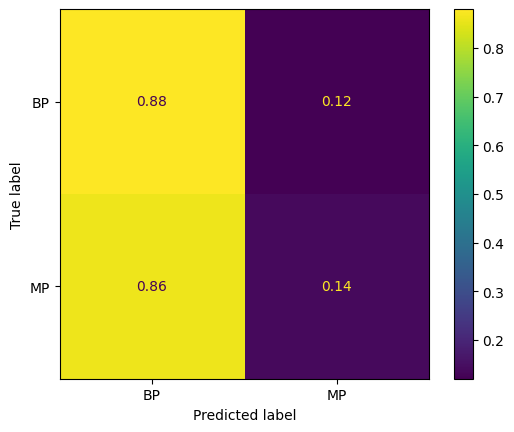

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = [0,1]
label_names = ['BP', 'MP']

disp = confusion_matrix_custom(y_test, y_pred)
disp.plot()

aval_dict['0 - inicial']=disp

# Análise Exploratória


Excluir variáveis através de análise exploratória (distribuição das variáveis)
Pensar Agrupamento de variáveis categóricas através da análise exploratória
Pensar Inputação através da análise exploratória

## Variáveis Categóricas

In [46]:
dados_ajustados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   DIA_PAGAMENTO                     50000 non-null  object 
 1   TIPO_ENVIO_APLICACAO              50000 non-null  object 
 2   TIPO_ENDERECO_POSTAL              50000 non-null  object 
 3   SEXO                              49935 non-null  object 
 4   ESTADO_CIVIL                      50000 non-null  object 
 5   QUANT_DEPENDENTES                 50000 non-null  int64  
 6   ESTADO_NASCIMENTO                 47935 non-null  object 
 7   NACIONALIDADE                     50000 non-null  object 
 8   ESTADO_RESIDENCIAL                50000 non-null  object 
 9   FLAG_TELEFONE_RESIDENCIAL         50000 non-null  bool   
 10  TIPO_RESIDENCIA                   48651 non-null  object 
 11  MESES_RESIDENCIA                  46223 non-null  object 
 12  FLAG

In [47]:
categorical_features = dados_ajustados.select_dtypes(include=['bool','object']).columns.tolist()
categorical_features

['DIA_PAGAMENTO',
 'TIPO_ENVIO_APLICACAO',
 'TIPO_ENDERECO_POSTAL',
 'SEXO',
 'ESTADO_CIVIL',
 'ESTADO_NASCIMENTO',
 'NACIONALIDADE',
 'ESTADO_RESIDENCIAL',
 'FLAG_TELEFONE_RESIDENCIAL',
 'TIPO_RESIDENCIA',
 'MESES_RESIDENCIA',
 'FLAG_EMAIL',
 'FLAG_VISA',
 'FLAG_MASTERCARD',
 'FLAG_DINERS',
 'FLAG_AMERICAN_EXPRESS',
 'FLAG_OUTROS_CARTOES',
 'EMPRESA',
 'ESTADO_PROFISSIONAL',
 'FLAG_TELEFONE_PROFISSIONAL',
 'CODIGO_PROFISSAO',
 'TIPO_OCUPACAO',
 'CODIGO_PROFISSAO_CONJUGE',
 'NIVEL_EDUCACIONAL_CONJUGE',
 'PRODUTO',
 'MAU_PAGADOR']

### Histograma

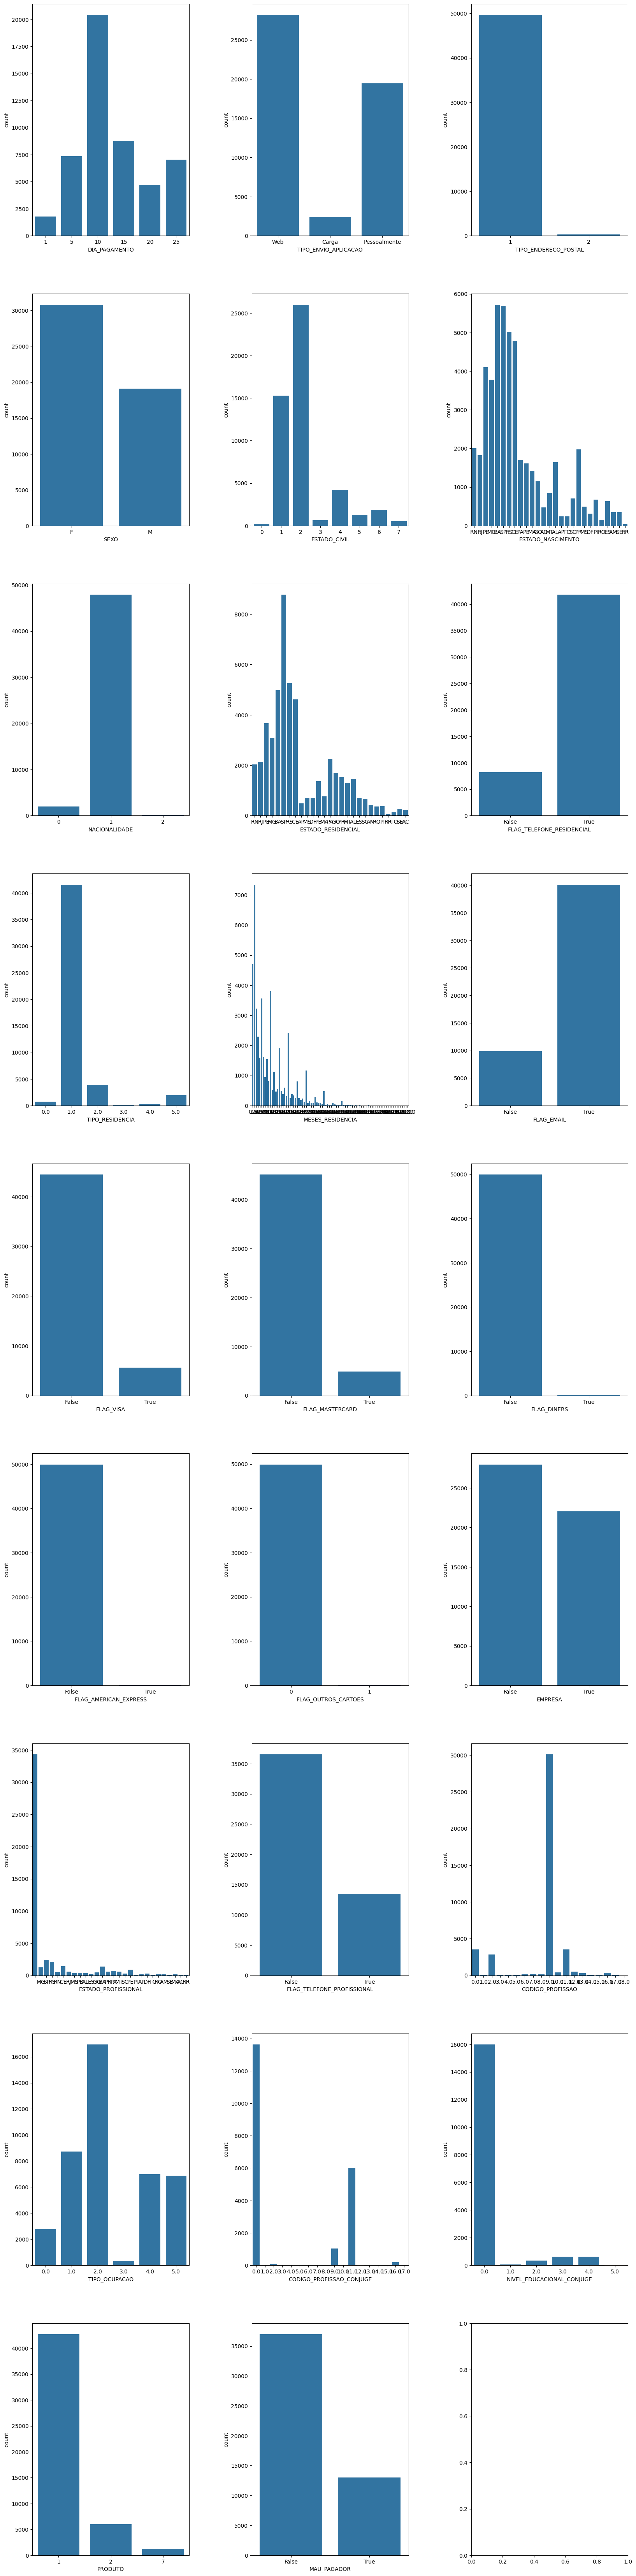

In [48]:
# Análise das variáveis qualitativas
# features=categorical_features[0:10]
features=categorical_features
fig,axs=plt.subplots(nrows=math.ceil(len(categorical_features)/3), ncols=3, figsize=(18,len(categorical_features)*3))

for col, ax in zip(features[0:], axs.ravel()):
    x=dados_ajustados.loc[:, col]
    ax.set_xlabel(col)
    sns.countplot(x=x, ax=ax, orient='v')
    plt.subplots_adjust(top=0.92,bottom=0.08, left=0.10,right=0.95,hspace=0.25,wspace=0.4)

plt.show()

### Teste Chi Quadrado

In [49]:
#Selecionando features categoricas para teste Chi Quadrado
categorical_features = dados_ajustados.select_dtypes(include=['bool','object']).columns.tolist()
categorical_features

['DIA_PAGAMENTO',
 'TIPO_ENVIO_APLICACAO',
 'TIPO_ENDERECO_POSTAL',
 'SEXO',
 'ESTADO_CIVIL',
 'ESTADO_NASCIMENTO',
 'NACIONALIDADE',
 'ESTADO_RESIDENCIAL',
 'FLAG_TELEFONE_RESIDENCIAL',
 'TIPO_RESIDENCIA',
 'MESES_RESIDENCIA',
 'FLAG_EMAIL',
 'FLAG_VISA',
 'FLAG_MASTERCARD',
 'FLAG_DINERS',
 'FLAG_AMERICAN_EXPRESS',
 'FLAG_OUTROS_CARTOES',
 'EMPRESA',
 'ESTADO_PROFISSIONAL',
 'FLAG_TELEFONE_PROFISSIONAL',
 'CODIGO_PROFISSAO',
 'TIPO_OCUPACAO',
 'CODIGO_PROFISSAO_CONJUGE',
 'NIVEL_EDUCACIONAL_CONJUGE',
 'PRODUTO',
 'MAU_PAGADOR']

In [50]:
from scipy.stats import chi2_contingency

explainer_categorical_features=categorical_features.copy()
explainer_categorical_features.remove('MAU_PAGADOR')

independent_features=[]
dependent_features=[]


alpha = 0.05
for feature in explainer_categorical_features:
    contigency= pd.crosstab(dados_ajustados[feature], dados_ajustados['MAU_PAGADOR']).reset_index(drop=True)
    stat, p, dof, expected = chi2_contingency(contigency)
    print(f'Teste Qui Quadrado entre MAU_PAGADOR e {feature}')
    print(f"p value = " + str(p))
    

    if p <= alpha:
        print(f'MAU_PAGADOR e {feature} são dependentes (reject H0)\n')
        dependent_features.append(feature)
    else:
        print(f'MAU_PAGADOR e {feature} são independentes (H0 holds true)\n')
        independent_features.append(feature)
        
print(f'Features independentes em relação a MAU PAGADOR {independent_features}\n')
print(f'Features dependentes em relação a MAU PAGADOR {dependent_features}')

Teste Qui Quadrado entre MAU_PAGADOR e DIA_PAGAMENTO
p value = 2.0625221684567212e-68
MAU_PAGADOR e DIA_PAGAMENTO são dependentes (reject H0)

Teste Qui Quadrado entre MAU_PAGADOR e TIPO_ENVIO_APLICACAO
p value = 6.530688628000474e-06
MAU_PAGADOR e TIPO_ENVIO_APLICACAO são dependentes (reject H0)

Teste Qui Quadrado entre MAU_PAGADOR e TIPO_ENDERECO_POSTAL
p value = 0.632177180746252
MAU_PAGADOR e TIPO_ENDERECO_POSTAL são independentes (H0 holds true)

Teste Qui Quadrado entre MAU_PAGADOR e SEXO
p value = 4.6747249182360754e-07
MAU_PAGADOR e SEXO são dependentes (reject H0)

Teste Qui Quadrado entre MAU_PAGADOR e ESTADO_CIVIL
p value = 1.7597142756980474e-53
MAU_PAGADOR e ESTADO_CIVIL são dependentes (reject H0)

Teste Qui Quadrado entre MAU_PAGADOR e ESTADO_NASCIMENTO
p value = 5.646623467815751e-15
MAU_PAGADOR e ESTADO_NASCIMENTO são dependentes (reject H0)

Teste Qui Quadrado entre MAU_PAGADOR e NACIONALIDADE
p value = 0.9660909448662429
MAU_PAGADOR e NACIONALIDADE são independentes

## Variáveis Numéricas

In [51]:
numerical_features = dados_ajustados.select_dtypes(include=['float64','int64']).columns.tolist()
dados_ajustados[numerical_features].describe()

,QUANT_DEPENDENTES,RENDA_PESSOAL_MENSAL,OUTRAS_RENDAS,QUANT_CONTAS_BANCARIAS,QUANT_CONTAS_BANCARIAS_ESPECIAIS,VALOR_PATRIMONIO_PESSOAL,QUANT_CARROS,MESES_NO_TRABALHO,IDADE
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.00000
mean,0.650520,886.678437,35.434760,0.357840,0.357840,2.322372e+03,0.336140,0.009320,43.24852
std,1.193655,7846.959327,891.515142,0.479953,0.479953,4.235798e+04,0.472392,0.383453,14.98905
min,0.000000,60.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,6.00000
25%,0.000000,360.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,31.00000
50%,0.000000,500.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,41.00000
75%,1.000000,800.000000,0.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,53.00000
max,53.000000,959000.000000,194344.000000,2.000000,2.000000,6.000000e+06,1.000000,35.000000,106.00000


### Visualização em Histograma

C:\Users\alber\AppData\Local\Temp\ipykernel_8676\2305018481.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, ax=ax, color="blue", kde=False)


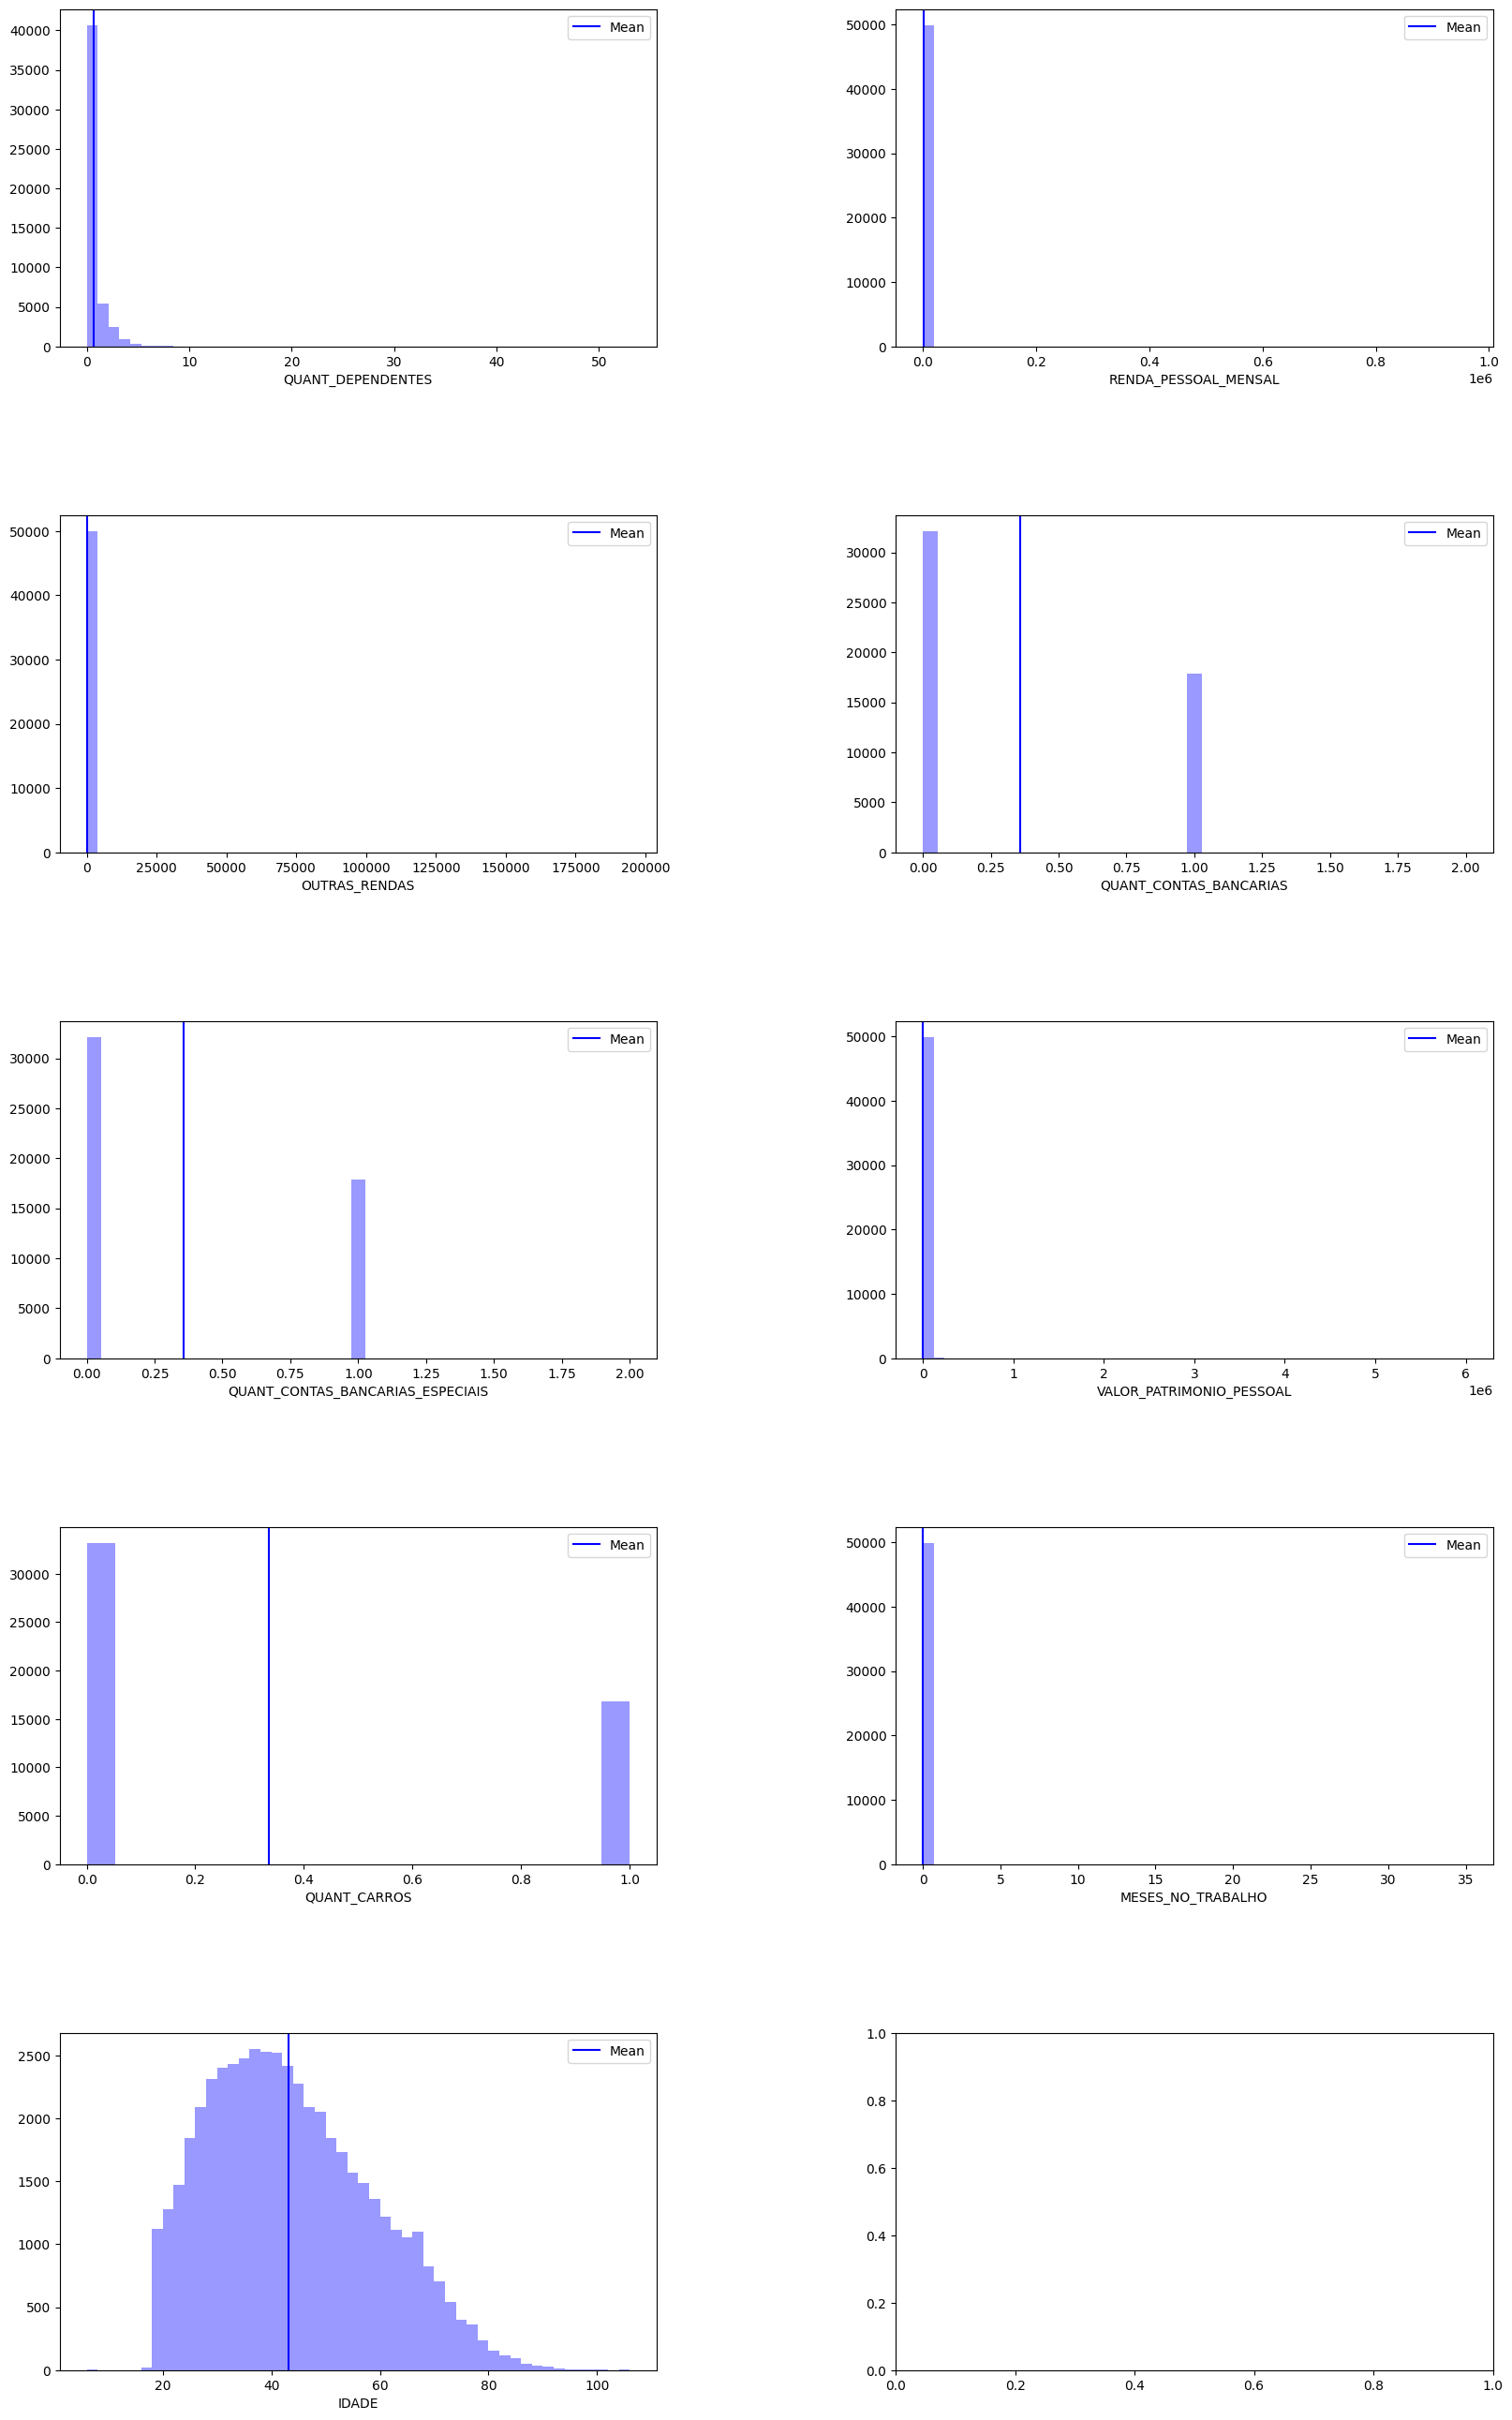

In [52]:
# Análise exploratória dos dados usando o gráfico histograma
# configurando figure
n_cols=2
n_rows=nrows=math.ceil(len(numerical_features)/n_cols)
fig,axs=plt.subplots(nrows=n_rows,
                     ncols=n_cols,
                     figsize=(18,n_rows*6))

for col, ax in zip(numerical_features[0:], axs.ravel()):
    x=dados_ajustados.loc[:, col]
    ax.set_xlabel(col)
    # ax.axvline(x=outlier_limits.loc[col]['upper_limit'], color='r', label='Upper limit')
    # ax.axvline(x=outlier_limits.loc[col]['lower_limit'], color='g', label='lower limit')
    ax.axvline(x=x.mean(), color='b', label='Mean')
    sns.distplot(x, ax=ax, color="blue", kde=False)
    ax.legend()
    plt.subplots_adjust(top=0.92,bottom=0.08, left=0.10,right=0.95,hspace=0.5,wspace=0.4)

plt.show()

### Visualização em boxplot

Vamos analisar as features ['RENDA_PESSOAL_MENSAL',
                       'OUTRAS_RENDAS',
                       'VALOR_PATRIMONIO_PESSOAL',
                       'MESES_NO_TRABALHO']
                    
                    
Quase a totalidade das entradas tem valor 0 nessas features. Provavelmente é um erro de entrada e devemos avaliar essas features.

<Axes: >

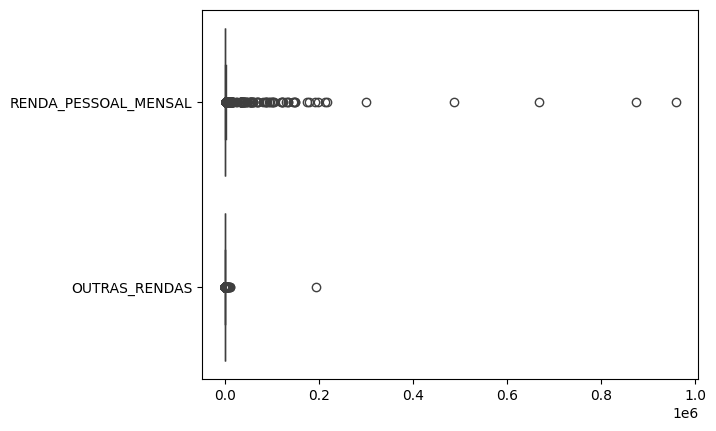

In [53]:
sns.boxplot(data=dados_ajustados[['RENDA_PESSOAL_MENSAL',
                       'OUTRAS_RENDAS',
                       ]],
            orient='h',
           )

Text(0.5, 1.0, 'Valor Patrimonio Pessoal')

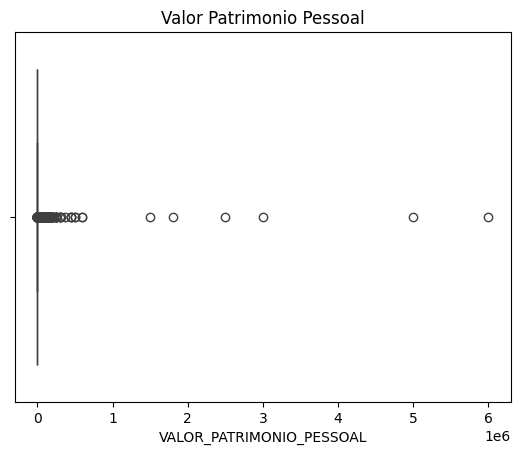

In [54]:
sns.boxplot(data=dados_ajustados['VALOR_PATRIMONIO_PESSOAL'],
            orient='h',
           ).set_title("Valor Patrimonio Pessoal")

Text(0.5, 1.0, 'Meses no Trabalho')

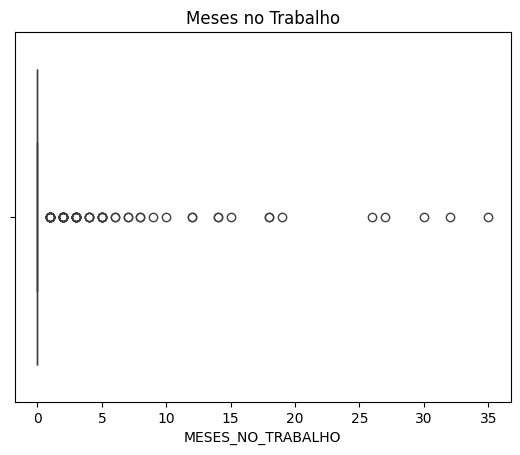

In [55]:
sns.boxplot(data=dados_ajustados['MESES_NO_TRABALHO'],
            orient='h'
           ).set_title("Meses no Trabalho")




A Variável quantidade de dependentes também tem outliers - Existem uma entrada com 53 dependentes

In [56]:
dados_ajustados[dados_ajustados['QUANT_DEPENDENTES']>=53]
                
                

,DIA_PAGAMENTO,TIPO_ENVIO_APLICACAO,TIPO_ENDERECO_POSTAL,SEXO,ESTADO_CIVIL,QUANT_DEPENDENTES,ESTADO_NASCIMENTO,NACIONALIDADE,ESTADO_RESIDENCIAL,FLAG_TELEFONE_RESIDENCIAL,...,ESTADO_PROFISSIONAL,FLAG_TELEFONE_PROFISSIONAL,MESES_NO_TRABALHO,CODIGO_PROFISSAO,TIPO_OCUPACAO,CODIGO_PROFISSAO_CONJUGE,NIVEL_EDUCACIONAL_CONJUGE,PRODUTO,IDADE,MAU_PAGADOR
40462,20,Pessoalmente,1,F,2,53,PE,1,PE,True,...,,False,0,9.0,2.0,NaN,NaN,1,48,False


<Axes: >

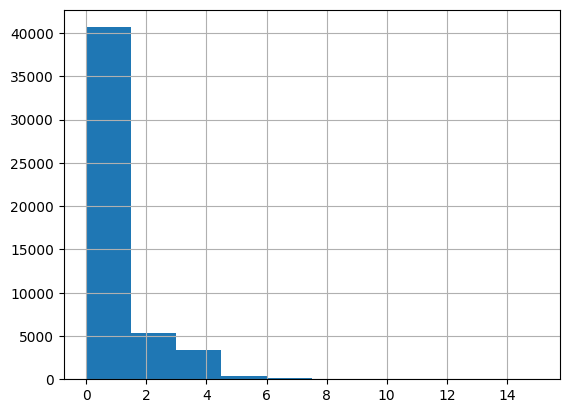

In [57]:
dados_ajustados[dados_ajustados['QUANT_DEPENDENTES']<53]['QUANT_DEPENDENTES'].hist()

### Coeficiente de Pearson

In [58]:
dados_ajustados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   DIA_PAGAMENTO                     50000 non-null  object 
 1   TIPO_ENVIO_APLICACAO              50000 non-null  object 
 2   TIPO_ENDERECO_POSTAL              50000 non-null  object 
 3   SEXO                              49935 non-null  object 
 4   ESTADO_CIVIL                      50000 non-null  object 
 5   QUANT_DEPENDENTES                 50000 non-null  int64  
 6   ESTADO_NASCIMENTO                 47935 non-null  object 
 7   NACIONALIDADE                     50000 non-null  object 
 8   ESTADO_RESIDENCIAL                50000 non-null  object 
 9   FLAG_TELEFONE_RESIDENCIAL         50000 non-null  bool   
 10  TIPO_RESIDENCIA                   48651 non-null  object 
 11  MESES_RESIDENCIA                  46223 non-null  object 
 12  FLAG

<Axes: >

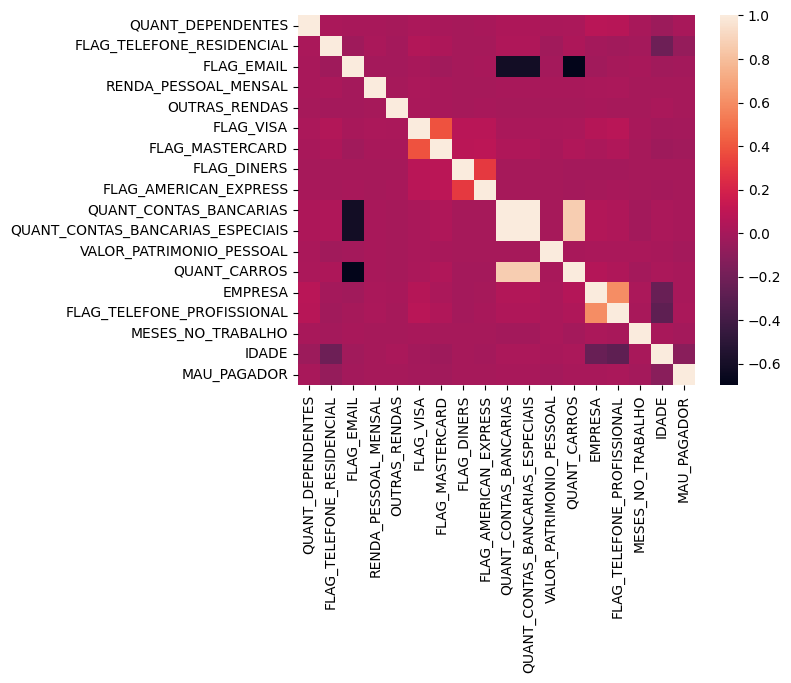

In [59]:
sns.heatmap(dados_ajustados.corr(numeric_only=True))

# Inputação de Dados
Dropar Features com mais de 20% de missing values

Inputar variáveis categóricas pela moda

Estudar utilizar modelo não supervisionado para inputar (KNN) - https://www.analyticsvidhya.com/blog/2021/04/how-to-handle-missing-values-of-categorical-variables/

Temos as seguintes Features com dados faltantes

In [60]:
## Copiando df para dados
dados=dados_ajustados.copy()

In [61]:
missingValues_features=dados.isnull().any()[dados.isnull().any()==True].index.to_list()
dados[missingValues_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   SEXO                       49935 non-null  object
 1   ESTADO_NASCIMENTO          47935 non-null  object
 2   TIPO_RESIDENCIA            48651 non-null  object
 3   MESES_RESIDENCIA           46223 non-null  object
 4   CODIGO_PROFISSAO           42244 non-null  object
 5   TIPO_OCUPACAO              42687 non-null  object
 6   CODIGO_PROFISSAO_CONJUGE   21116 non-null  object
 7   NIVEL_EDUCACIONAL_CONJUGE  17662 non-null  object
dtypes: object(8)
memory usage: 3.1+ MB


## Informações do conjuge


In [62]:
####NÂO FUNCIONOU ################

##Como temos muitas informacoes faltantes em relação ao conjuge e não temos nenhuma informação em relação
##a codificação do estado civil, vamos testar se os NA nas features CODIGO_PROFISSAO_CONJUGE e NIVEL_EDUCACIONAL_CONJUGE são para pessoas solteiras 

# conjuge=dados[['ESTADO_CIVIL','CODIGO_PROFISSAO_CONJUGE','NIVEL_EDUCACIONAL_CONJUGE']].copy()
# conjuge.fillna('NaN', inplace=True)
# conjuge.info()
# estados_civil=conjuge["ESTADO_CIVIL"].unique().tolist()
# estados_civil


# fig,axs=plt.subplots(nrows=6, ncols=3, figsize=(18,6*5.5))

# index=0

# for estado in estados_civil:
#     for column in ['CODIGO_PROFISSAO_CONJUGE','NIVEL_EDUCACIONAL_CONJUGE']:
#         x=conjuge[conjuge['ESTADO_CIVIL']==estado].copy()
#         plt.figure(figsize=(10, 6))
#         ax=axs.ravel()[index]
#         ax.set_title(f'{column} for estado civil {estado}')
#         sns.countplot(data=x,x=column, orient='v',ax=ax)
#         index+=1                           
#         plt.subplots_adjust(top=0.92,bottom=0.08, left=0.10,right=0.95,hspace=0.25,wspace=0.4)


# plt.show()



# #Não foi possível chegar a conclusão nenhuma, então iremos com a tag na+feature name
# columns=['CODIGO_PROFISSAO_CONJUGE', 'NIVEL_EDUCACIONAL_CONJUGE']
# for column in columns:
#     dados[column].fillna('Nan '+column,inplace=True)
    
    
# dados.info()

As Features CODIGO_PROFISSAO_CONJUGE e NIVEL_EDUCACIONAL_CONJUGE tem mais de 20% de missing values e serão descartadas

In [63]:
dados.drop(columns=['CODIGO_PROFISSAO_CONJUGE', 'NIVEL_EDUCACIONAL_CONJUGE'],inplace=True)
missingValues_features=dados.isnull().any()[dados.isnull().any()==True].index.to_list()
dados[missingValues_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   SEXO               49935 non-null  object
 1   ESTADO_NASCIMENTO  47935 non-null  object
 2   TIPO_RESIDENCIA    48651 non-null  object
 3   MESES_RESIDENCIA   46223 non-null  object
 4   CODIGO_PROFISSAO   42244 non-null  object
 5   TIPO_OCUPACAO      42687 non-null  object
dtypes: object(6)
memory usage: 2.3+ MB


## Inputação pela Moda

As variáveis ['SEXO','TIPO_RESIDENCIA','CODIGO_PROFISSAO', 'TIPO_OCUPACAO'] vão ser substituidas pela moda.

As váriaveis ['MESES_RESIDENCIA','ESTADO_NASCIMENTO'] será descartada por não terem um moda forte.

Vamos inputar pela moda, nossos clientes são majoritariamente femininos,

In [64]:
drop=['MESES_RESIDENCIA','ESTADO_NASCIMENTO'] 
features_drop=Union(features_drop,drop)

In [65]:
for feature in missingValues_features:
    print(dados[feature].value_counts(normalize =True).round(2))
    print('\n')

SEXO
F    0.62
M    0.38
Name: proportion, dtype: float64


ESTADO_NASCIMENTO
BA    0.12
SP    0.12
RS    0.10
CE    0.10
PE    0.09
MG    0.08
RN    0.04
PR    0.04
RJ    0.04
PA    0.04
AL    0.03
PB    0.03
MA    0.03
GO    0.02
MT    0.02
SC    0.01
PI    0.01
ES    0.01
MS    0.01
AC    0.01
SE    0.01
AM    0.01
DF    0.01
TO    0.01
AP    0.00
RO    0.00
RR    0.00
Name: proportion, dtype: float64


TIPO_RESIDENCIA
1.0    0.85
2.0    0.08
5.0    0.04
0.0    0.02
4.0    0.01
3.0    0.00
Name: proportion, dtype: float64


MESES_RESIDENCIA
1.0      0.16
0.0      0.10
10.0     0.08
5.0      0.08
2.0      0.07
         ... 
71.0     0.00
90.0     0.00
82.0     0.00
100.0    0.00
89.0     0.00
Name: proportion, Length: 88, dtype: float64


CODIGO_PROFISSAO
9.0     0.71
11.0    0.08
0.0     0.08
2.0     0.07
12.0    0.01
10.0    0.01
16.0    0.01
13.0    0.01
7.0     0.01
8.0     0.00
6.0     0.00
15.0    0.00
17.0    0.00
4.0     0.00
3.0     0.00
5.0     0.00
14.0    0.00
1.0     0.0

In [66]:
#Inputando pela moda e salvando as informação de inputação em input_dict={
input_dict={}

for feature in missingValues_features:
    input_=dados[feature].mode()[0]
    dados[feature]=dados[feature].fillna(input_)
    input_dict[feature]=input_
    
dados[missingValues_features].info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SEXO               50000 non-null  object 
 1   ESTADO_NASCIMENTO  50000 non-null  object 
 2   TIPO_RESIDENCIA    50000 non-null  float64
 3   MESES_RESIDENCIA   50000 non-null  float64
 4   CODIGO_PROFISSAO   50000 non-null  float64
 5   TIPO_OCUPACAO      50000 non-null  float64
dtypes: float64(4), object(2)
memory usage: 2.3+ MB


In [67]:
##Transformando as features  em objects novamente
missingValues_features
for column in missingValues_features:
    dados[column]=dados[column].astype(object)
                        
dados[missingValues_features].info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   SEXO               50000 non-null  object
 1   ESTADO_NASCIMENTO  50000 non-null  object
 2   TIPO_RESIDENCIA    50000 non-null  object
 3   MESES_RESIDENCIA   50000 non-null  object
 4   CODIGO_PROFISSAO   50000 non-null  object
 5   TIPO_OCUPACAO      50000 non-null  object
dtypes: object(6)
memory usage: 2.3+ MB


# Codificação e Dumetização

dumetizar tudo


features_to_transform=['DIA_PAGAMENTO','QUANT_CARTOES_ADICIONAIS','TIPO_ENDERECO_POSTAL','ESTADO_CIVIL','NIVEL_EDUCACIONAL','NACIONALIDADE','TIPO_RESIDENCIA','MESES_RESIDENCIA',
                       'FLAG_OUTROS_CARTOES','CODIGO_PROFISSAO','TIPO_OCUPACAO','CODIGO_PROFISSAO_CONJUGE','NIVEL_EDUCACIONAL_CONJUGE','PRODUTO']

In [68]:
to_dummy_features = dados.select_dtypes(include=['object']).columns.tolist()
to_dummy_features
to_dummy_features

['DIA_PAGAMENTO',
 'TIPO_ENVIO_APLICACAO',
 'TIPO_ENDERECO_POSTAL',
 'SEXO',
 'ESTADO_CIVIL',
 'ESTADO_NASCIMENTO',
 'NACIONALIDADE',
 'ESTADO_RESIDENCIAL',
 'TIPO_RESIDENCIA',
 'MESES_RESIDENCIA',
 'FLAG_OUTROS_CARTOES',
 'ESTADO_PROFISSIONAL',
 'CODIGO_PROFISSAO',
 'TIPO_OCUPACAO',
 'PRODUTO']

In [69]:
for feature in to_dummy_features:
    print(f'{feature} - chaves: {dados[feature].unique()}')

DIA_PAGAMENTO - chaves: [5 15 20 10 25 1]
TIPO_ENVIO_APLICACAO - chaves: ['Web' 'Carga' 'Pessoalmente']
TIPO_ENDERECO_POSTAL - chaves: [1 2]
SEXO - chaves: ['F' 'M']
ESTADO_CIVIL - chaves: [6 2 1 5 3 7 4 0]
ESTADO_NASCIMENTO - chaves: ['RN' 'RJ' 'PE' 'MG' 'BA' 'SP' 'RS' 'CE' 'PA' 'PB' 'MA' 'GO' 'AC' 'MT'
 'AL' 'AP' 'TO' 'SC' 'PR' 'MS' 'DF' 'PI' 'RO' 'ES' 'AM' 'SE' 'RR']
NACIONALIDADE - chaves: [1 0 2]
ESTADO_RESIDENCIAL - chaves: ['RN' 'RJ' 'PE' 'MG' 'BA' 'SP' 'RS' 'CE' 'AP' 'MS' 'DF' 'PB' 'MA' 'PA'
 'GO' 'PR' 'MT' 'AL' 'ES' 'SC' 'AM' 'RO' 'PI' 'RR' 'TO' 'SE' 'AC']
TIPO_RESIDENCIA - chaves: [1.0 2.0 5.0 0.0 3.0 4.0]
MESES_RESIDENCIA - chaves: [15.0 1.0 12.0 4.0 0.0 5.0 10.0 6.0 2.0 3.0 18.0 25.0 14.0 16.0 8.0 7.0
 20.0 9.0 17.0 30.0 11.0 37.0 22.0 33.0 26.0 40.0 32.0 29.0 23.0 13.0 36.0
 45.0 60.0 34.0 21.0 31.0 35.0 38.0 39.0 24.0 19.0 48.0 28.0 52.0 49.0
 46.0 27.0 42.0 62.0 51.0 82.0 44.0 68.0 71.0 50.0 47.0 41.0 57.0 69.0
 55.0 200.0 53.0 100.0 72.0 43.0 70.0 54.0 56.0 80.0 65.0 90

## Dumetizando Dados

In [70]:
X=dados.drop('MAU_PAGADOR', axis=1)
y=dados['MAU_PAGADOR']

for feature in to_dummy_features:
    aux = pd.get_dummies(X[feature],drop_first=False)
    X.drop([feature],axis=1,inplace=True)
    X=pd.concat([X,aux],axis=1)
    
X.columns = X.columns.astype(str) 
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 247 entries, QUANT_DEPENDENTES to 7
dtypes: bool(238), float64(3), int64(6)
memory usage: 14.8 MB


Separando em test e Train

In [71]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=42)

## Avaliação

In [72]:
from sklearn.neighbors import KNeighborsClassifier
Classif_KNN = KNeighborsClassifier(n_neighbors=k)
Classif_KNN.fit(X_train, y_train)
y_pred = Classif_KNN.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.74      0.89      0.81     11076
        True       0.30      0.14      0.19      3924

    accuracy                           0.69     15000
   macro avg       0.52      0.51      0.50     15000
weighted avg       0.63      0.69      0.65     15000

0.6896


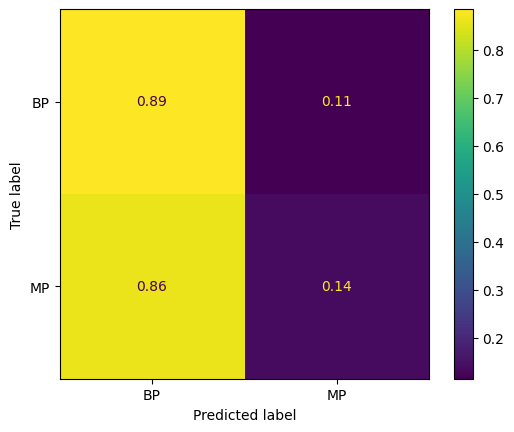

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = confusion_matrix_custom(y_test, y_pred).plot()

aval_dict['1 - Inputação']=disp

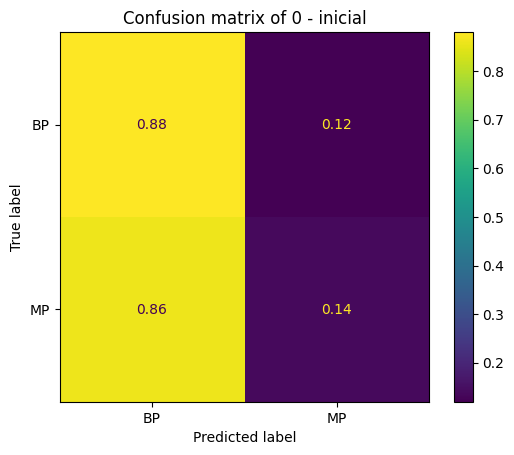

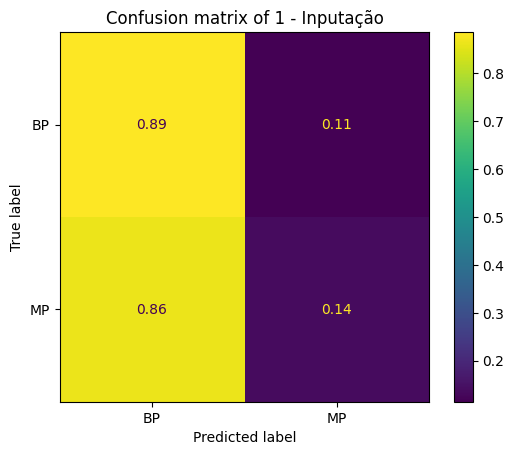

In [74]:
for key in aval_dict:
    aval_dict[key].plot()
    plt.title(f'Confusion matrix of {key}')

## Agrupando Features numéricas em  categorias
['VALOR_PATRIMONIO_PESSOAL','MESES_NO_TRABALHO','QUANT_DEPENDENTES','RENDA_PESSOAL_MENSAL','OUTRAS_RENDAS']

In [75]:
features_CATEGORIZE=['VALOR_PATRIMONIO_PESSOAL','MESES_NO_TRABALHO','QUANT_DEPENDENTES','RENDA_PESSOAL_MENSAL','OUTRAS_RENDAS']

In [76]:
#Copíando dados
dados_agrupados=dados.copy()

### Categorizando ['VALOR_PATRIMONIO_PESSOAL','MESES_NO_TRABALHO',','RENDA_PESSOAL_MENSAL','OUTRAS_RENDAS']

Muito valores 0 são e vamos considerá-los como ausentes

In [77]:
dados[dados['VALOR_PATRIMONIO_PESSOAL']>0][['VALOR_PATRIMONIO_PESSOAL']].describe()
# Bin edges must be unique:

,VALOR_PATRIMONIO_PESSOAL
count,2.391000e+03
mean,4.856488e+04
std,1.878512e+05
min,1.000000e+00
25%,1.875000e+04
50%,3.000000e+04
75%,5.000000e+04
max,6.000000e+06


<Axes: xlabel='patrimonio_bins'>

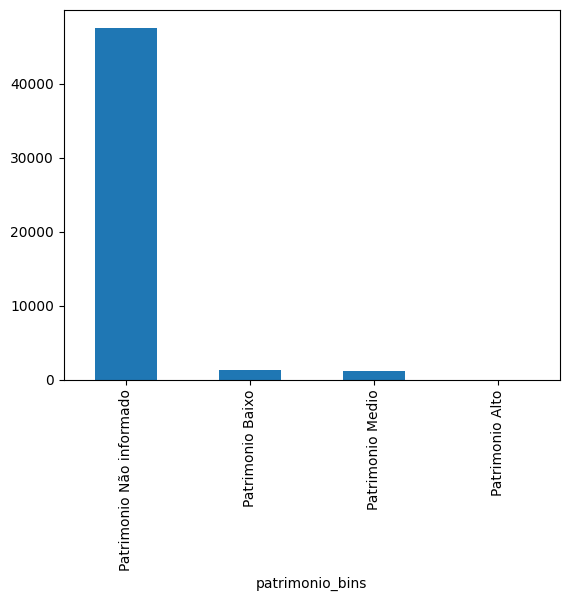

In [78]:
dados_agrupados["patrimonio_bins"] = pd.cut(
        x=dados_agrupados["VALOR_PATRIMONIO_PESSOAL"],
        bins=[-1, 1,3e+04,5e+5, np.inf],
        labels=["Patrimonio Não informado", "Patrimonio Baixo", "Patrimonio Medio", "Patrimonio Alto"]
        )

dados_agrupados["patrimonio_bins"].value_counts().plot(kind='bar')    
# data['Points'].value_counts().plot(ax=ax, kind='bar')

### Categorizando MESES_NO_TRABALHO

<Axes: ylabel='Frequency'>

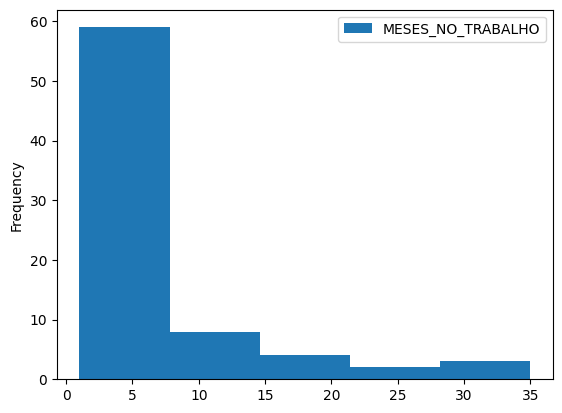

In [79]:
dados[dados['MESES_NO_TRABALHO']>0][['MESES_NO_TRABALHO']].plot(kind='hist',bins=5)

<Axes: xlabel='meses_bins'>

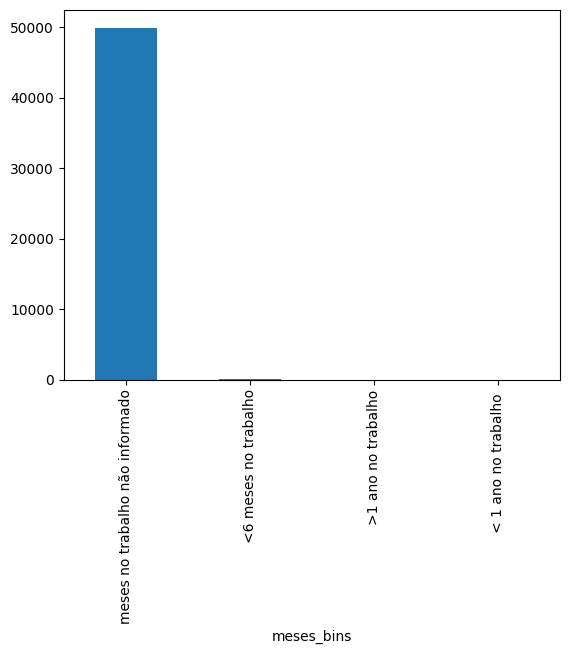

In [80]:
dados_agrupados["meses_bins"] = pd.cut(
        x=dados_agrupados["MESES_NO_TRABALHO"],
        bins=[-1, 1,6,12, np.inf],
        labels=["meses no trabalho não informado", "<6 meses no trabalho", "< 1 ano no trabalho ", ">1 ano no trabalho"]
        )

dados_agrupados["meses_bins"].value_counts().plot(kind='bar')   

'RENDA_PESSOAL_MENSAL'

In [81]:
feature='RENDA_PESSOAL_MENSAL'
dados[feature].describe()

count     50000.000000
mean        886.678437
std        7846.959327
min          60.000000
25%         360.000000
50%         500.000000
75%         800.000000
max      959000.000000
Name: RENDA_PESSOAL_MENSAL, dtype: float64

<Axes: xlabel='RENDA_PESSOAL_MENSAL_bins'>

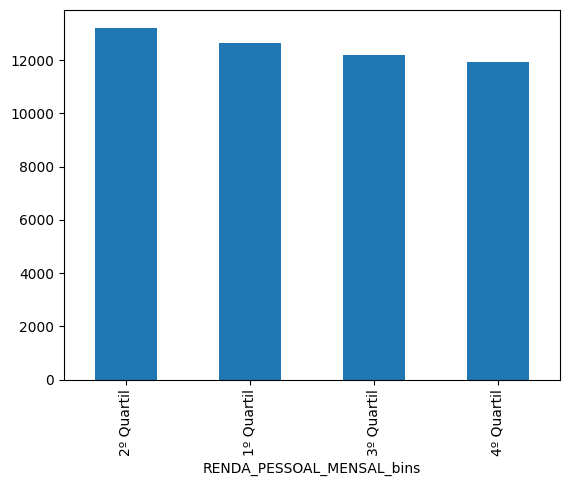

In [82]:
dados_agrupados[feature+"_bins"] = pd.qcut(
        x=dados_agrupados[feature],
        q=4,
        labels=['1º Quartil','2º Quartil','3º Quartil','4º Quartil']
        )

dados_agrupados[feature+"_bins"].value_counts().plot(kind='bar')   

'OUTRAS_RENDAS'

In [83]:
feature='OUTRAS_RENDAS'
dados[dados[feature]>0][feature].describe()

count      2773.000000
mean        638.924627
std        3734.996041
min           1.000000
25%         300.000000
50%         400.000000
75%         650.000000
max      194344.000000
Name: OUTRAS_RENDAS, dtype: float64

<Axes: xlabel='OUTRAS_RENDAS_bins'>

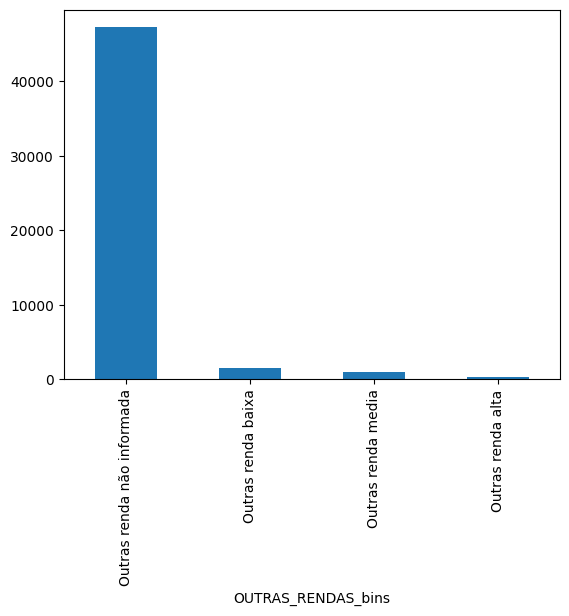

In [84]:
dados_agrupados[feature+"_bins"] = pd.cut(
        x=dados_agrupados[feature],
        bins=[-50, 1,400,1000, np.inf],
        labels=['Outras renda não informada',"Outras renda baixa", "Outras renda media", "Outras renda alta"]
        )

dados_agrupados[feature+"_bins"].value_counts().plot(kind='bar')   

### Avaliando


In [85]:
X=dados.drop('MAU_PAGADOR', axis=1)
y=dados['MAU_PAGADOR']

for feature in to_dummy_features:
    aux = pd.get_dummies(X[feature],drop_first=False)
    X.drop([feature],axis=1,inplace=True)
    X=pd.concat([X,aux],axis=1)
    
X.columns = X.columns.astype(str) 
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 247 entries, QUANT_DEPENDENTES to 7
dtypes: bool(238), float64(3), int64(6)
memory usage: 14.8 MB


In [86]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=42)

In [87]:
from sklearn.neighbors import KNeighborsClassifier
Classif_KNN = KNeighborsClassifier(n_neighbors=k)
Classif_KNN.fit(X_train, y_train)
y_pred = Classif_KNN.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.74      0.89      0.81     11076
        True       0.30      0.14      0.19      3924

    accuracy                           0.69     15000
   macro avg       0.52      0.51      0.50     15000
weighted avg       0.63      0.69      0.65     15000

0.6896


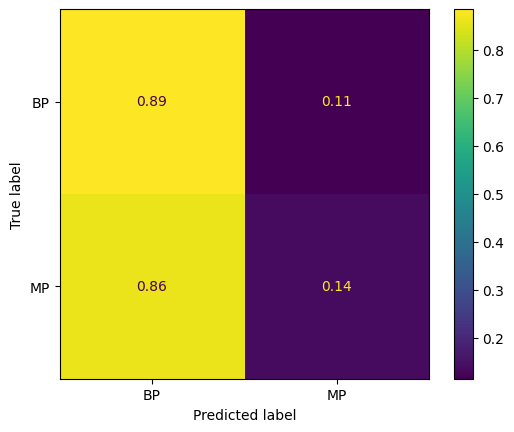

In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = confusion_matrix_custom(y_test, y_pred).plot()

aval_dict['1.1 - agrupamento']=disp

# Scalling dos Dados
Testar e avaliar para todos:
* Standard
* Robust Scaller
* min/max



## Normalização - Standard Scaling


In [89]:
numerical_features = dados.select_dtypes(include=['float64','int64']).columns.tolist()
numerical_features

['QUANT_DEPENDENTES',
 'RENDA_PESSOAL_MENSAL',
 'OUTRAS_RENDAS',
 'QUANT_CONTAS_BANCARIAS',
 'QUANT_CONTAS_BANCARIAS_ESPECIAIS',
 'VALOR_PATRIMONIO_PESSOAL',
 'QUANT_CARROS',
 'MESES_NO_TRABALHO',
 'IDADE']

### Scaling individual

Fazendo o Scaling uma feature de cada vez

In [90]:
from sklearn.preprocessing import StandardScaler

#Separando os dados
X_train_StandardScaled,X_test_StandardScaled,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=42)

#Treinando o modelo
Classif_KNN = KNeighborsClassifier(n_neighbors=k)
Classif_KNN.fit(X_train_StandardScaled, y_train)
y_pred = Classif_KNN.predict(X_test_StandardScaled)

#Printando o recall para comparação
print((recall_score(y_test, y_pred, average=None)[1]))

#Scalling individual de cada feature
chosen_scaler=StandardScaler

for column in numerical_features:
    X_train_StandardScaled,X_test_StandardScaled,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=42)
    scaler = chosen_scaler().fit(X_train_StandardScaled[column].values.reshape(-1, 1))

    X_train_StandardScaled[column] = scaler.transform(X_train_StandardScaled[column].values.reshape(-1, 1))
    X_test_StandardScaled[column] = scaler.transform(X_test_StandardScaled[column].values.reshape(-1, 1))
    Classif_KNN = KNeighborsClassifier(n_neighbors=k)
    Classif_KNN.fit(X_train_StandardScaled, y_train)
    y_pred = Classif_KNN.predict(X_test_StandardScaled)
    print(f'Feature com Scalling: {column}\nRecall = {recall_score(y_test, y_pred, average=None)[1]}')

0.1365953109072375
Feature com Scalling: QUANT_DEPENDENTES
Recall = 0.13557594291539246
Feature com Scalling: RENDA_PESSOAL_MENSAL
Recall = 0.15010193679918452
Feature com Scalling: OUTRAS_RENDAS
Recall = 0.1373598369011213
Feature com Scalling: QUANT_CONTAS_BANCARIAS
Recall = 0.1317533129459735
Feature com Scalling: QUANT_CONTAS_BANCARIAS_ESPECIAIS
Recall = 0.13200815494393475
Feature com Scalling: VALOR_PATRIMONIO_PESSOAL
Recall = 0.13404689092762487
Feature com Scalling: QUANT_CARROS
Recall = 0.1325178389398573
Feature com Scalling: MESES_NO_TRABALHO
Recall = 0.13685015290519878
Feature com Scalling: IDADE
Recall = 0.13786952089704382


### Preparo

In [91]:
from sklearn.preprocessing import StandardScaler

# X_train_StandardScaled,X_test_StandardScaled,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=42)
# scaler = StandardScaler().fit(X_train_StandardScaled)

# X_train_StandardScaled = scaler.transform(X_train_StandardScaled)
# X_test_StandardScaled = scaler.transform(X_test_StandardScaled)

# Scalling somente em variaveis numericas
X_train_StandardScaled,X_test_StandardScaled,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler().fit(X_train_StandardScaled[numerical_features])

X_train_StandardScaled[numerical_features] = scaler.transform(X_train_StandardScaled[numerical_features])
X_test_StandardScaled[numerical_features] = scaler.transform(X_test_StandardScaled[numerical_features])

### Treino

In [92]:
Classif_KNN = KNeighborsClassifier(n_neighbors=k)
Classif_KNN.fit(X_train_StandardScaled, y_train)
y_pred = Classif_KNN.predict(X_test_StandardScaled)
print((recall_score(y_test, y_pred, average=None)[1]))

0.15112130479102956


### Avaliação

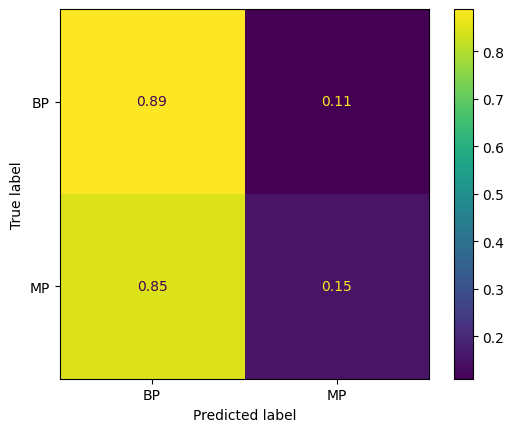

In [93]:
disp = confusion_matrix_custom(y_test, y_pred).plot()
aval_dict['2 - Standard Scaler']=disp

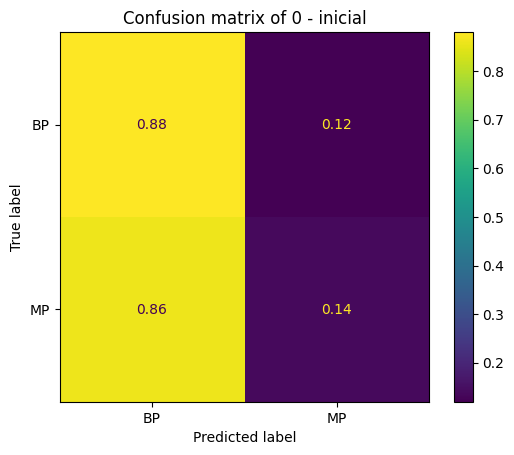

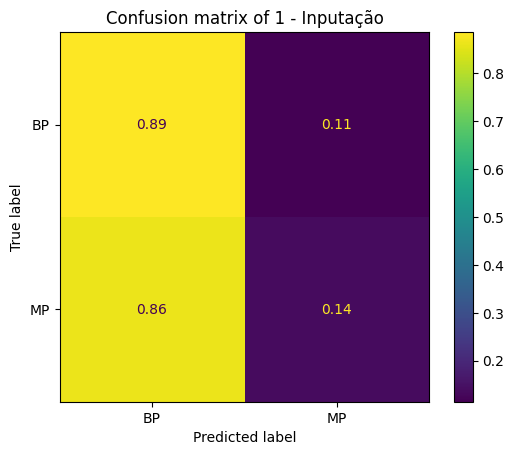

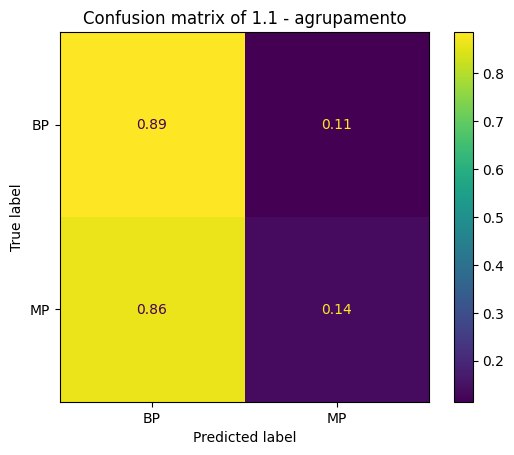

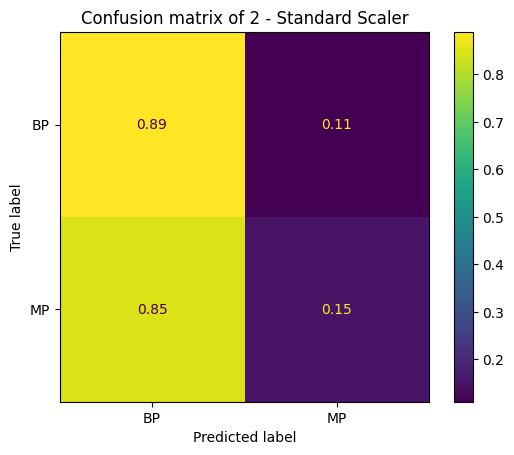

In [94]:
for key in aval_dict:
    aval_dict[key].plot()
    plt.title(f'Confusion matrix of {key}')

Scaling uma a uma

## Min/Max Scaling

### Scaling individual

Fazendo o Scaling uma feature de cada vez

In [95]:
from sklearn.preprocessing import MinMaxScaler

chosen_scaler= MinMaxScaler

for column in numerical_features:
    #Split dos dados
    X_train_Scaled,X_test_Scaled,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=42)
    #Fit do scaler
    scaler = chosen_scaler().fit(X_train_Scaled[column].values.reshape(-1, 1))
    #Scallin dos dados
    X_train_Scaled[column] = scaler.transform(X_train_Scaled[column].values.reshape(-1, 1))
    X_test_Scaled[column] = scaler.transform(X_test_Scaled[column].values.reshape(-1, 1))
    #Treinamento do modelo
    Classif_KNN = KNeighborsClassifier(n_neighbors=k)
    Classif_KNN.fit(X_train_Scaled, y_train)
    #Predição
    y_pred = Classif_KNN.predict(X_test_Scaled)
    #Avaliação
    print(f'Feature com Scalling: {column}\nRecall = {recall_score(y_test, y_pred, average=None)[1]}')

Feature com Scalling: QUANT_DEPENDENTES
Recall = 0.13837920489296637
Feature com Scalling: RENDA_PESSOAL_MENSAL
Recall = 0.15010193679918452
Feature com Scalling: OUTRAS_RENDAS
Recall = 0.13761467889908258
Feature com Scalling: QUANT_CONTAS_BANCARIAS
Recall = 0.13608562691131498
Feature com Scalling: QUANT_CONTAS_BANCARIAS_ESPECIAIS
Recall = 0.13608562691131498
Feature com Scalling: VALOR_PATRIMONIO_PESSOAL
Recall = 0.13302752293577982
Feature com Scalling: QUANT_CARROS
Recall = 0.1365953109072375
Feature com Scalling: MESES_NO_TRABALHO
Recall = 0.13634046890927626
Feature com Scalling: IDADE
Recall = 0.1358307849133537


### Preparo

In [96]:
#Escalando só numéricas
from sklearn.preprocessing import MinMaxScaler

X_train_MinMaxScaled,X_test_MinMaxScaled,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=42)
scaler = MinMaxScaler().fit(X_train_MinMaxScaled[numerical_features])

X_train_MinMaxScaled[numerical_features] = scaler.transform(X_train_MinMaxScaled[numerical_features])
X_test_MinMaxScaled[numerical_features] = scaler.transform(X_test_MinMaxScaled[numerical_features])

### Treino

In [97]:
#Treino do modelo
Classif_KNN = KNeighborsClassifier(n_neighbors=k)
Classif_KNN.fit(X_train_MinMaxScaled, y_train)

#Predição
y_pred = Classif_KNN.predict(X_test_MinMaxScaled)

#Avaliação
print("Recall =", (recall_score(y_test, y_pred, average=None)[1]))
print('Accuracy',(accuracy_score(y_test, y_pred)))

Recall = 0.14551478083588176
Accuracy 0.6920666666666667


### Avaliação

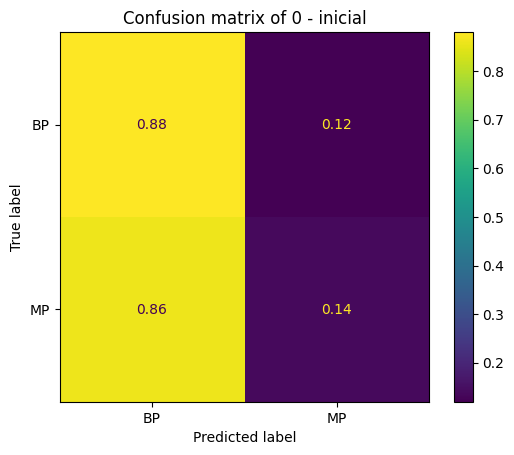

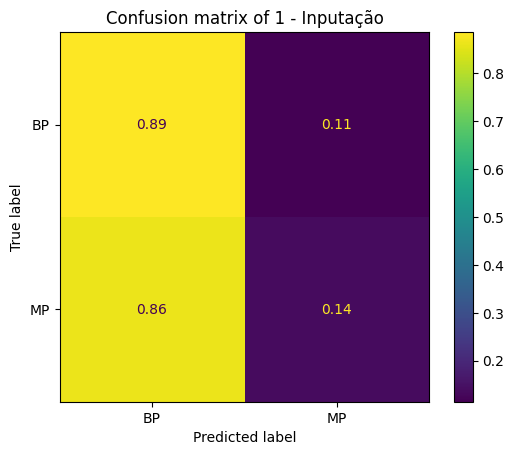

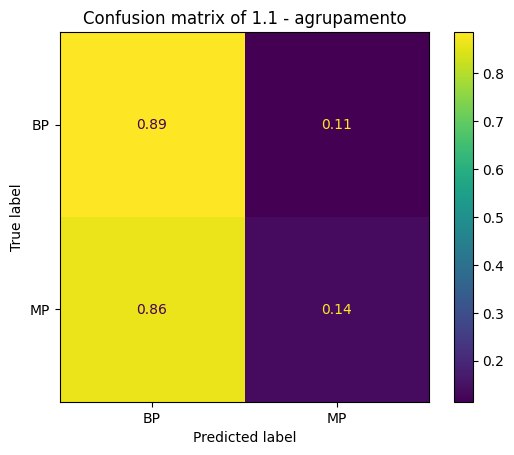

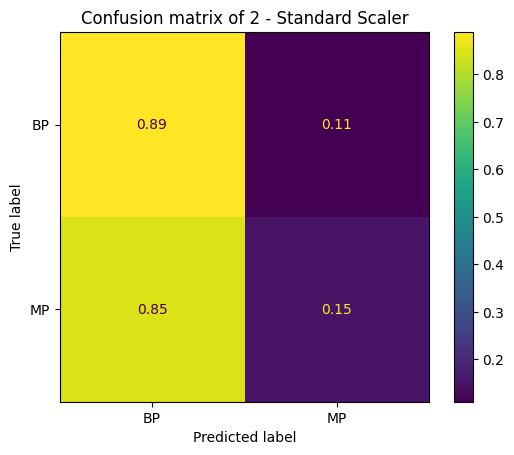

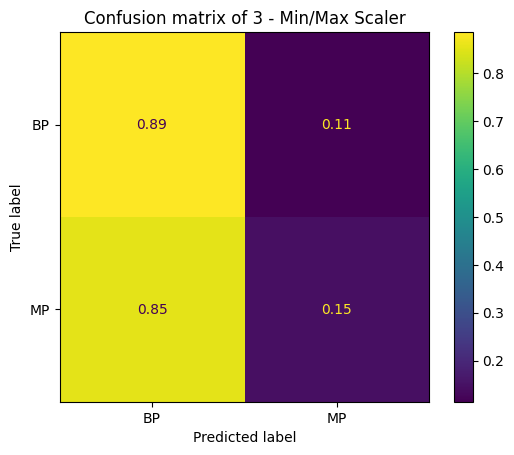

In [98]:
disp = confusion_matrix_custom(y_test, y_pred)
aval_dict['3 - Min/Max Scaler']=disp

for key in aval_dict:
    aval_dict[key].plot()
    plt.title(f'Confusion matrix of {key}')

## Robust Scaling

### Scaling Individual
Fazendo o Scaling uma feature de cada vez

In [99]:
from sklearn.preprocessing import RobustScaler

chosen_scaler=  RobustScaler

for column in numerical_features:
    #Split dos dados
    X_train_Scaled,X_test_Scaled,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=42)
    
    #Fit do scaler
    scaler = chosen_scaler().fit(X_train_Scaled[column].values.reshape(-1, 1))
    
    #Scallin dos dados
    X_train_Scaled[column] = scaler.transform(X_train_Scaled[column].values.reshape(-1, 1))
    X_test_Scaled[column] = scaler.transform(X_test_Scaled[column].values.reshape(-1, 1))
    
    #Treinamento do modelo
    Classif_KNN = KNeighborsClassifier(n_neighbors=k)
    Classif_KNN.fit(X_train_Scaled, y_train)
    
    #Predição
    y_pred = Classif_KNN.predict(X_test_Scaled)
    
    #Avaliação
    print(f'Feature com Scalling: {column}\nRecall = {recall_score(y_test, y_pred, average=None)[1]}')

Feature com Scalling: QUANT_DEPENDENTES
Recall = 0.1365953109072375
Feature com Scalling: RENDA_PESSOAL_MENSAL
Recall = 0.14041794087665646
Feature com Scalling: OUTRAS_RENDAS
Recall = 0.1365953109072375
Feature com Scalling: QUANT_CONTAS_BANCARIAS
Recall = 0.1365953109072375
Feature com Scalling: QUANT_CONTAS_BANCARIAS_ESPECIAIS
Recall = 0.1365953109072375
Feature com Scalling: VALOR_PATRIMONIO_PESSOAL
Recall = 0.1365953109072375
Feature com Scalling: QUANT_CARROS
Recall = 0.1365953109072375
Feature com Scalling: MESES_NO_TRABALHO
Recall = 0.1365953109072375
Feature com Scalling: IDADE
Recall = 0.13863404689092762


### Preparo

In [100]:
X_train_RobustScaled,X_test_RobustScaled,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=42)
scaler = RobustScaler().fit(X_train_RobustScaled[numerical_features])

X_train_RobustScaled[numerical_features] = scaler.transform(X_train_RobustScaled[numerical_features])
X_test_RobustScaled[numerical_features] = scaler.transform(X_test_RobustScaled[numerical_features])

### Treino

In [101]:
Classif_KNN = KNeighborsClassifier(n_neighbors=k)
Classif_KNN.fit(X_train_RobustScaled, y_train)
y_pred = Classif_KNN.predict(X_test_RobustScaled)
print((recall_score(y_test, y_pred, average=None)[1]))

0.13761467889908258


### Avaliação

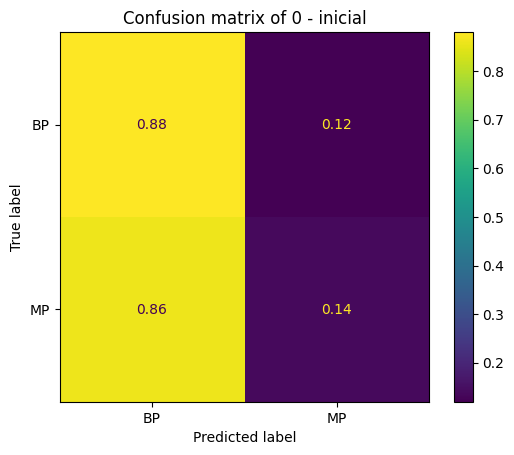

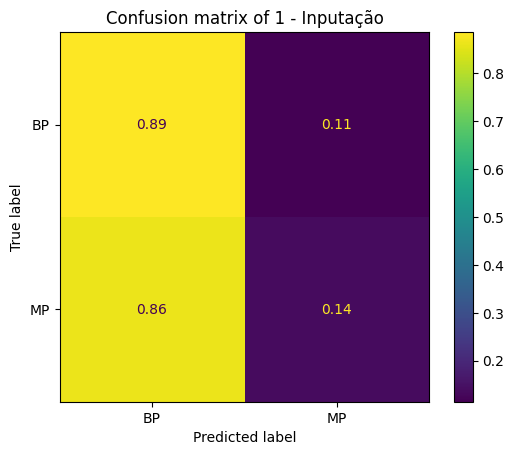

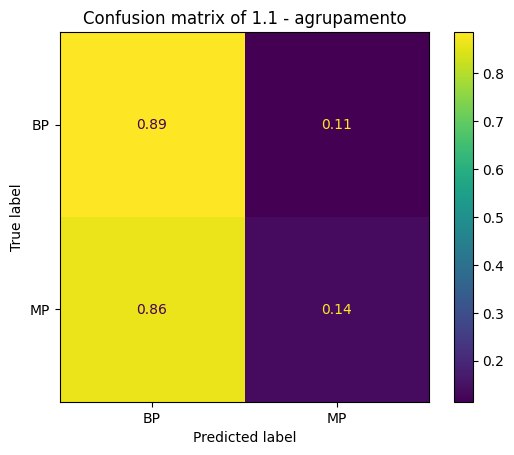

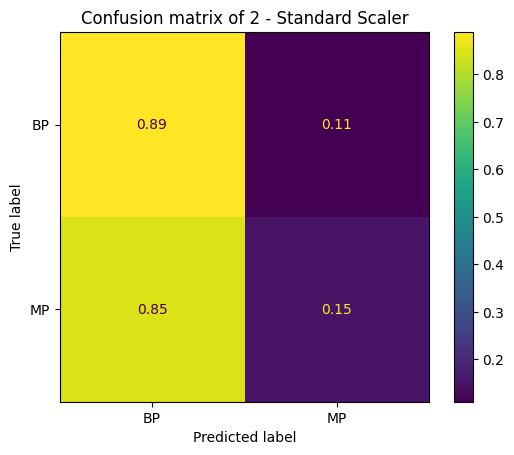

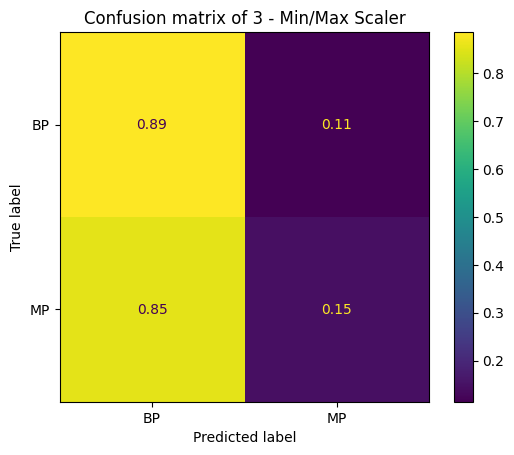

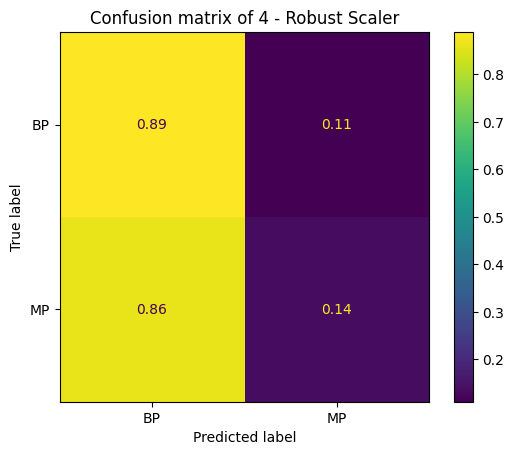

In [102]:
disp = confusion_matrix_custom(y_test, y_pred)
aval_dict['4 - Robust Scaler']=disp

for key in aval_dict:
    aval_dict[key].plot()
    plt.title(f'Confusion matrix of {key}')

## Conclusão
A melhor Scalling encontrada foi min max scaller com recall de 3%

O scalling de features individualmente não nos deu insights sobre e eficacia do scaling delas separadamente e não teve correlação com o scaling total

# Redução de Dimensionalidade 
Reduzir Dados Com PCA

## Modelo com redução de dimensionalidade
Objetivo diminuir o número de Features

<Axes: >

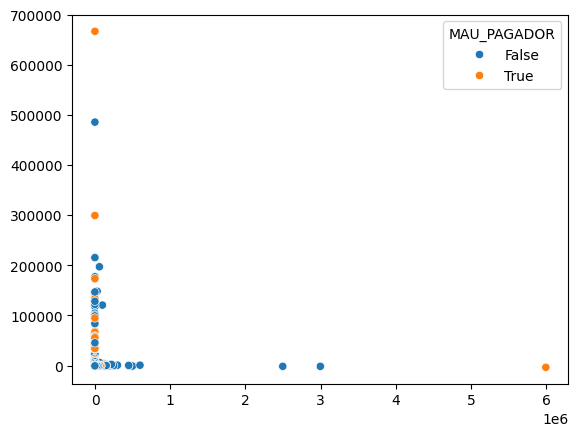

In [103]:
from sklearn.decomposition import PCA

#Redução de variáveis
pca = PCA(n_components=10,random_state=2)
pca_2d_train = pca.fit_transform(X_train_Scaled)
pca_2d_test = pca.transform(X_test_Scaled)

# Visualização de variáveis reduzidas
sns.scatterplot(x=pca_2d_train[:,0],y=pca_2d_train[:,1], hue=y_train,)

Text(0, 0.5, 'Testing Recall')

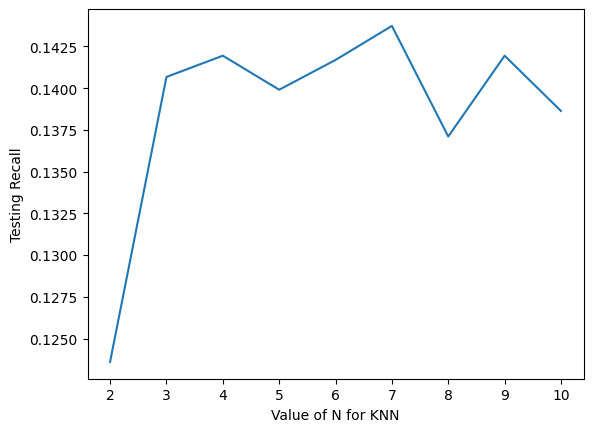

In [104]:
#Calculando melhor N
recall=[]
n_range=range(2,11)

for n in n_range:
    #Redução de variáveis
    pca = PCA(n_components=n,random_state=2)
    pca_2d_train = pca.fit_transform(X_train_MinMaxScaled)

    pca_2d_test = pca.transform(X_test_MinMaxScaled)
    
    #Treinando modelo
    Classif_KNN = KNeighborsClassifier(n_neighbors=k)
    Classif_KNN.fit(pca_2d_train, y_train)

    #Prevendo valores            
    y_pred = Classif_KNN.predict(pca_2d_test)
    recall.append(recall_score(y_test, y_pred, average=None)[1])

#Plota e salva os valores de acc. em função do valor escolhido de K
plt.plot(n_range, recall)
plt.xlabel('Value of N for KNN')
plt.ylabel('Testing Recall')

0.14041794087665646


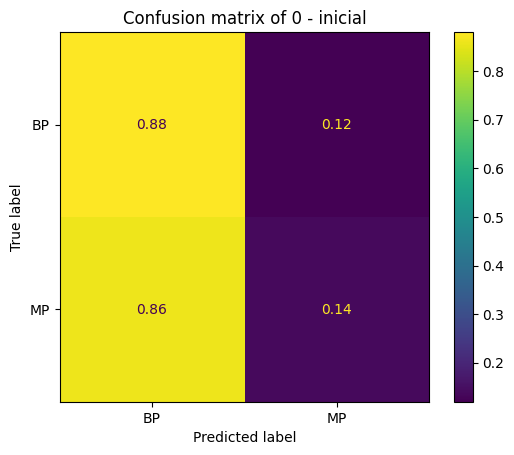

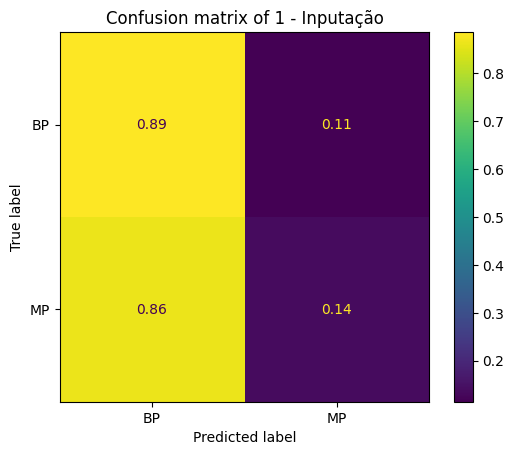

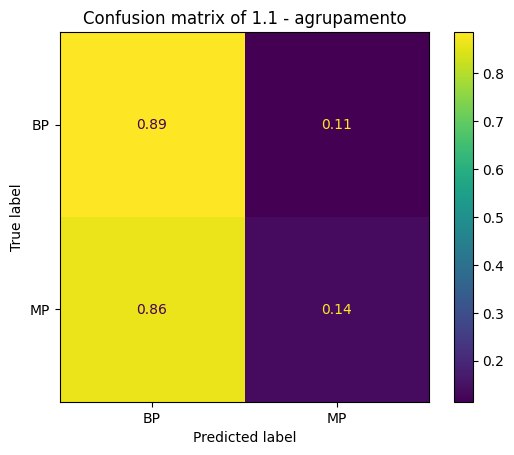

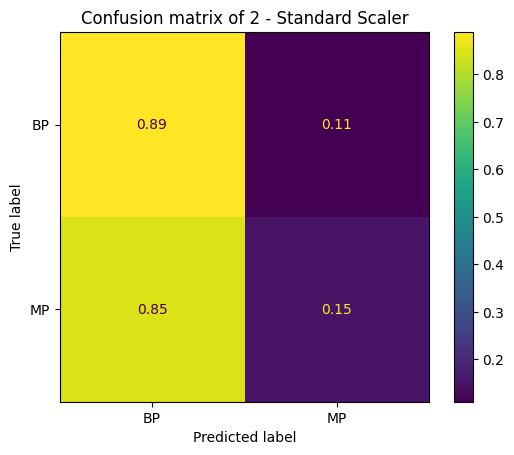

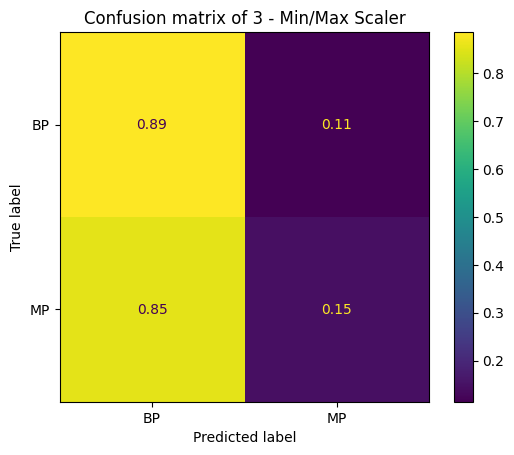

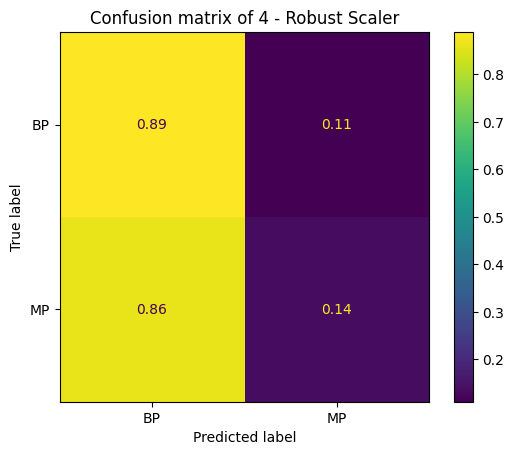

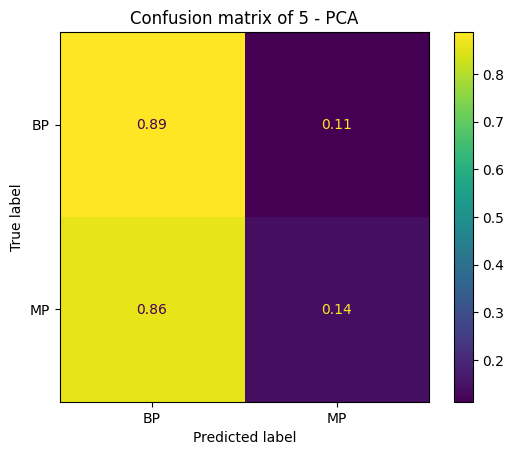

In [105]:
#Redução de variáveis
pca = PCA(n_components=5)
pca_2d_train = pca.fit_transform(X_train_MinMaxScaled)

pca_2d_test = pca.transform(X_test_MinMaxScaled)

#Treinando modelo
Classif_KNN = KNeighborsClassifier(n_neighbors=k)
Classif_KNN.fit(pca_2d_train, y_train)

#Prevendo valores            
y_pred = Classif_KNN.predict(pca_2d_test)
print(recall_score(y_test, y_pred, average=None)[1])

#Salvando informações
disp = confusion_matrix_custom(y_test, y_pred)
aval_dict['5 - PCA']=disp

for key in aval_dict:
    aval_dict[key].plot()
    plt.title(f'Confusion matrix of {key}')


Não obtivemos beneficios em fazer a redução de dimensionalidade então manteremos os dados escalonados pelo min/max

In [106]:
dependent_features

['DIA_PAGAMENTO',
 'TIPO_ENVIO_APLICACAO',
 'SEXO',
 'ESTADO_CIVIL',
 'ESTADO_NASCIMENTO',
 'ESTADO_RESIDENCIAL',
 'FLAG_TELEFONE_RESIDENCIAL',
 'TIPO_RESIDENCIA',
 'MESES_RESIDENCIA',
 'FLAG_MASTERCARD',
 'ESTADO_PROFISSIONAL',
 'FLAG_TELEFONE_PROFISSIONAL',
 'CODIGO_PROFISSAO',
 'TIPO_OCUPACAO',
 'CODIGO_PROFISSAO_CONJUGE',
 'NIVEL_EDUCACIONAL_CONJUGE',
 'PRODUTO']

# Exclusão de Outliers



['RENDA_PESSOAL_MENSAL','OUTRAS_RENDAS','VALOR_PATRIMONIO_PESSOAL','MESES_NO_TRABALHO'] estudar

Quant_dependentee 1,5*IQQ

## QUANT_DEPENDENTES

In [107]:
numerical_features

['QUANT_DEPENDENTES',
 'RENDA_PESSOAL_MENSAL',
 'OUTRAS_RENDAS',
 'QUANT_CONTAS_BANCARIAS',
 'QUANT_CONTAS_BANCARIAS_ESPECIAIS',
 'VALOR_PATRIMONIO_PESSOAL',
 'QUANT_CARROS',
 'MESES_NO_TRABALHO',
 'IDADE']

In [108]:
def calculate_bounds(df, column_name):
    # Calculate the IQR (Interquartile Range)
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1

    # Calculate the upper and lower bounds
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr

    return lower_bound, upper_bound

In [109]:
def remove_outliers(lower_bound,upper_bound,X,y,column):
    X_new=X.copy()
    y_new=y.copy()

    X_new.reset_index(inplace=True, drop=True)
    y_new.reset_index(inplace=True, drop=True)
    
    mask=(X_new[column]>=lower_bound) & (X_new[column] <= upper_bound)
    X_new=X_new[mask].copy()
    y_new=y_new.loc[X_new.index]
    
    X_new.reset_index(inplace=True, drop=True)
    y_new.reset_index(inplace=True, drop=True)
    
    return X_new,y_new
    

In [110]:
#Calculando limites
bounds=calculate_bounds(X_train_MinMaxScaled,'QUANT_DEPENDENTES')
bounds

(-0.1, 0.16666666666666669)

In [111]:
#Limpando dados
X_train_OutliersTreatment,y_train_OutliersTreatment=remove_outliers(bounds[0],bounds[1],X_train_MinMaxScaled,y_train,'QUANT_DEPENDENTES')

In [112]:
#Treinando modelo
Classif_KNN = KNeighborsClassifier(n_neighbors=k)
Classif_KNN.fit(X_train_OutliersTreatment, y_train_OutliersTreatment)
y_pred = Classif_KNN.predict(X_test_MinMaxScaled)
print("Recall = ",(recall_score(y_test, y_pred, average=None)[1]))
disp = confusion_matrix_custom(y_test, y_pred)

Recall =  0.1450050968399592


### Avaliação

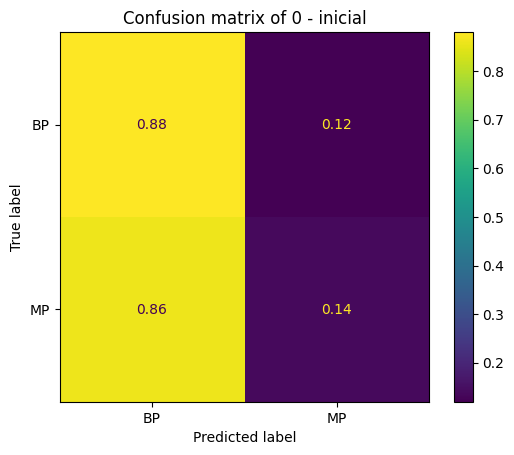

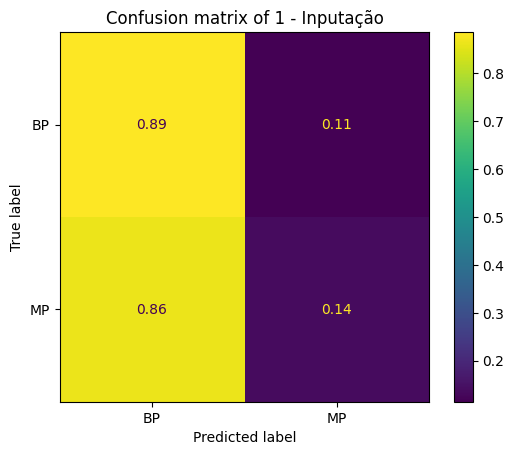

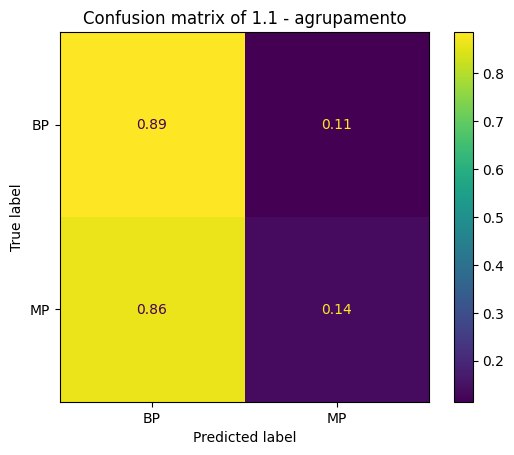

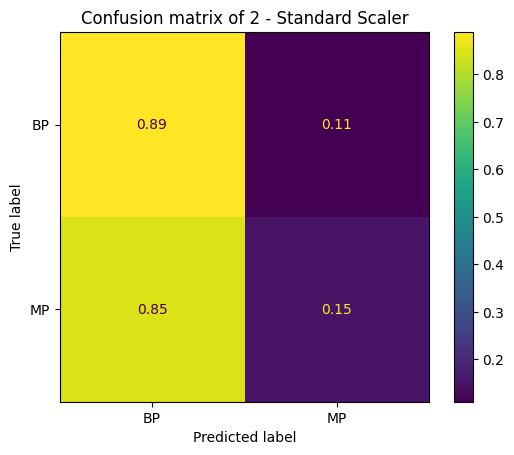

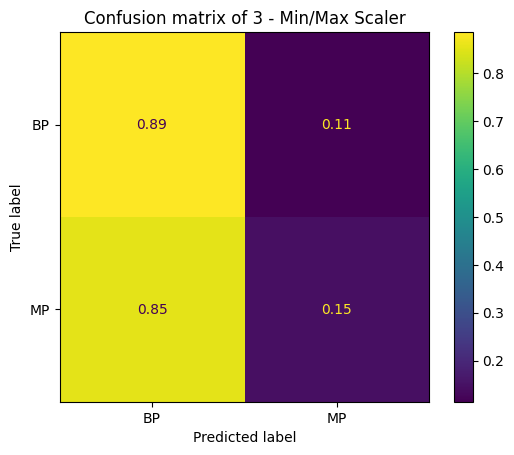

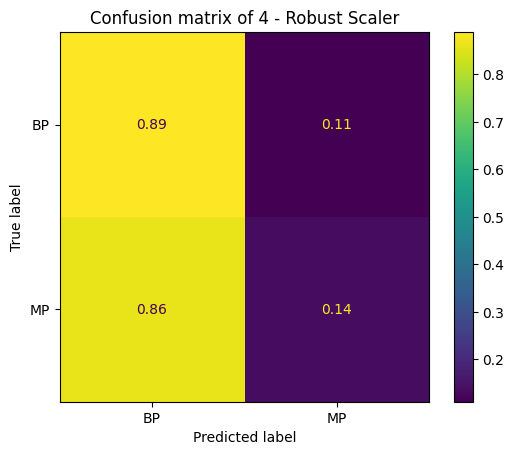

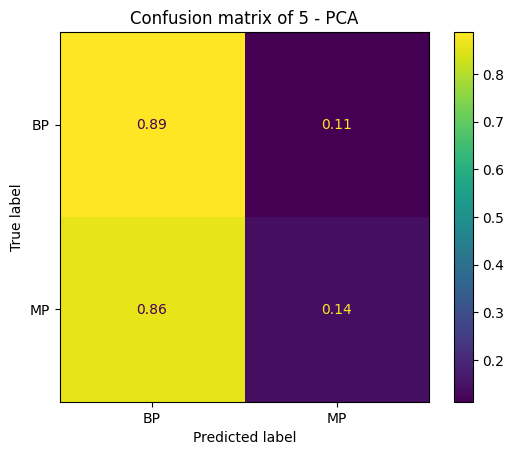

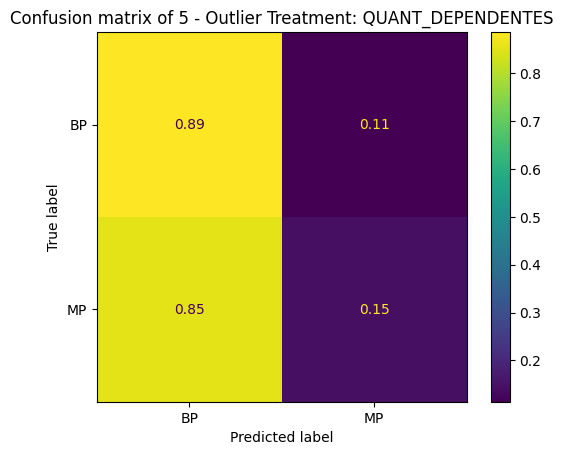

In [113]:
# Salvando avaliação
disp = confusion_matrix_custom(y_test, y_pred)
aval_dict['5 - Outlier Treatment: QUANT_DEPENDENTES']=disp

for key in aval_dict:
    aval_dict[key].plot()
    plt.title(f'Confusion matrix of {key}')

Recall melhorou muito com remoção de outliers então manteremos

## RENDA_PESSOAL_MENSAL, OUTRAS_RENDAS, VALOR_PATRIMONIO_PESSOAL, MESES_NO_TRABALHO

['RENDA_PESSOAL_MENSAL','OUTRAS_RENDAS','VALOR_PATRIMONIO_PESSOAL','MESES_NO_TRABALHO'] 

Já transformei em bins no item agrupando Features numéricas em categorias. deveria dropas as numericas

In [114]:
# X_train2=X_train_OutliersTreatment.drop(columns=['RENDA_PESSOAL_MENSAL','OUTRAS_RENDAS','VALOR_PATRIMONIO_PESSOAL','MESES_NO_TRABALHO'])
X_train_droped_columns=X_train_OutliersTreatment.drop(columns=['RENDA_PESSOAL_MENSAL','OUTRAS_RENDAS','VALOR_PATRIMONIO_PESSOAL','MESES_NO_TRABALHO'])
X_test_droped_columns=X_test_RobustScaled.drop(columns=['RENDA_PESSOAL_MENSAL','OUTRAS_RENDAS','VALOR_PATRIMONIO_PESSOAL','MESES_NO_TRABALHO'])

# df.drop(columns=['B', 'C'])

In [115]:
#Treinando modelo
Classif_KNN = KNeighborsClassifier(n_neighbors=k)
Classif_KNN.fit(X_train_droped_columns, y_train_OutliersTreatment)
y_pred = Classif_KNN.predict(X_test_droped_columns)
print((recall_score(y_test, y_pred, average=None)[1]))
disp = confusion_matrix_custom(y_test, y_pred)

0.15774719673802243


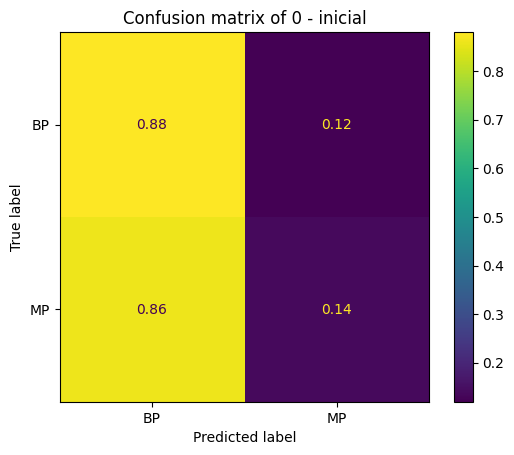

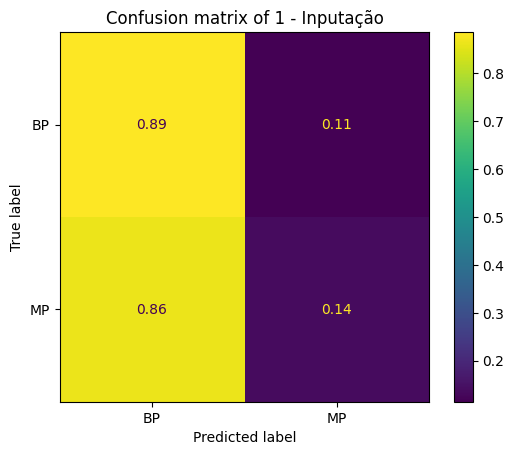

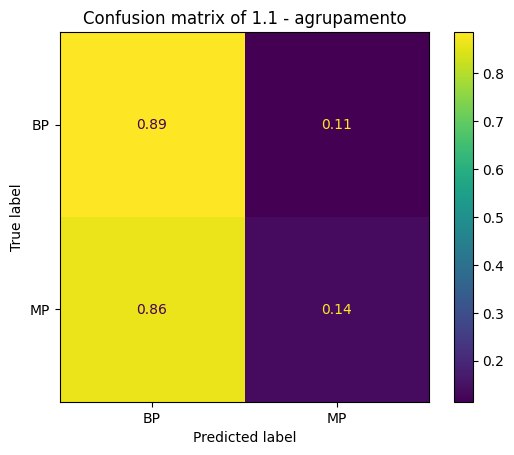

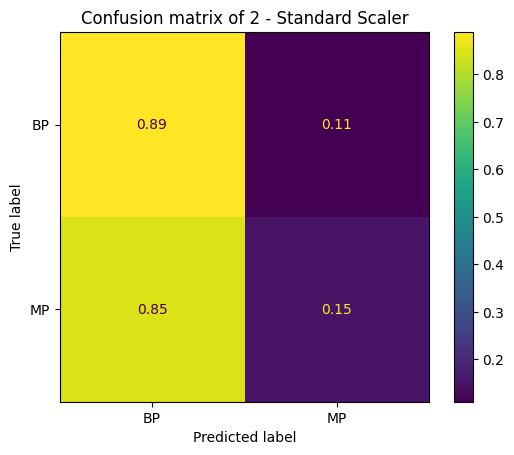

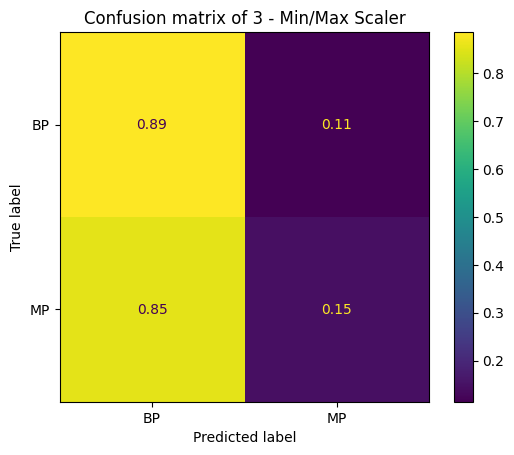

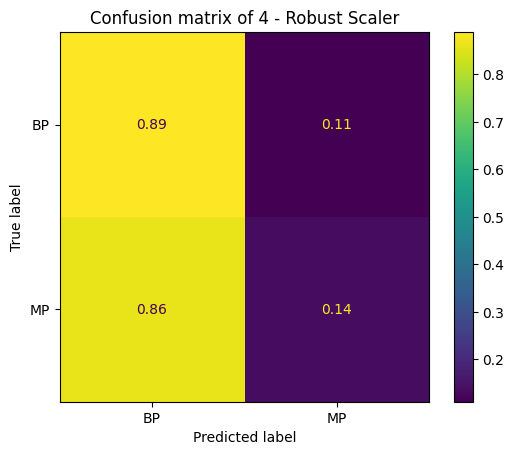

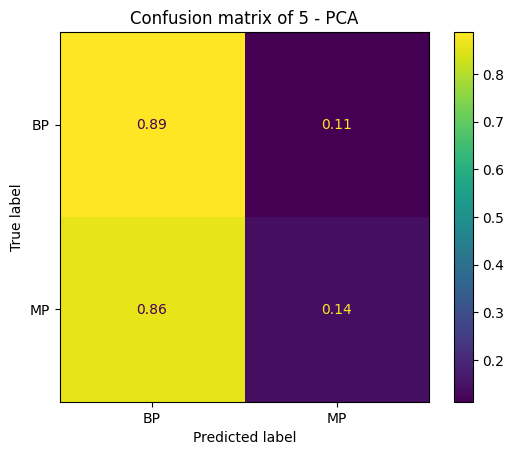

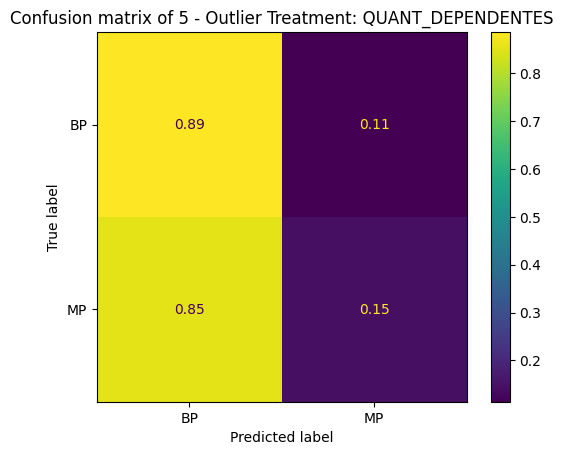

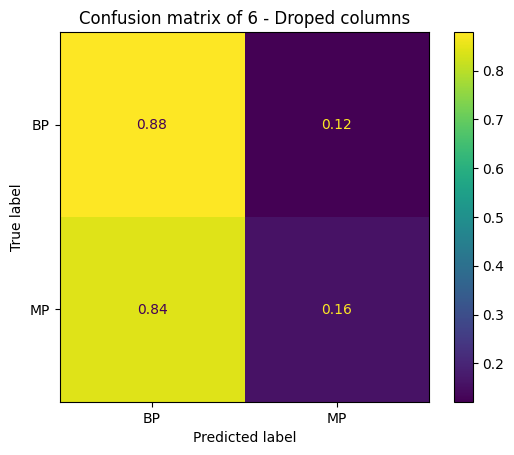

In [116]:
# Salvando avaliação
disp = confusion_matrix_custom(y_test, y_pred)
aval_dict['6 - Droped columns']=disp

for key in aval_dict:
    aval_dict[key].plot()
    plt.title(f'Confusion matrix of {key}')





## Avaliação
O melhor modelo encontrado foi o modelo 5 utilizando os seguites passos de tratamentos dos dados
Inputação -> Min/Max Scalling -> Exclusão de Outliers
Temos a seguinte matriz de confusão

Text(0.5, 1.0, 'Confusion matrix of 5 - Outlier Treatment: QUANT_DEPENDENTES')

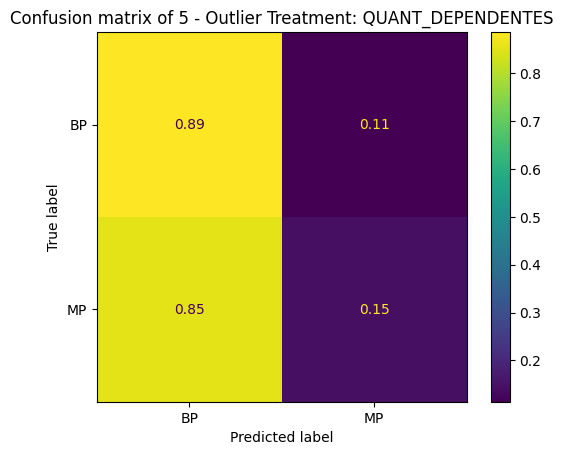

In [149]:
best_models={}
best_models['5 - Outlier Treatment: QUANT_DEPENDENTES']=aval_dict['5 - Outlier Treatment: QUANT_DEPENDENTES']
aval_dict['5 - Outlier Treatment: QUANT_DEPENDENTES'].plot()
plt.title(f'Confusion matrix of 5 - Outlier Treatment: QUANT_DEPENDENTES')

# Testando outro modos (Random Forest,NB, Gradient Boosting)

In [153]:


#Criando funcao para avaliar outros modelos
def EvalueteModel(model, x=X_train_OutliersTreatment, y= y_train_OutliersTreatment):

    model.fit(x,y)
    y_pred=model.predict(X_test_MinMaxScaled)
    
    
    disp = confusion_matrix_custom(y_test, y_pred)
    disp = confusion_matrix_custom(y_test, y_pred)
    return disp



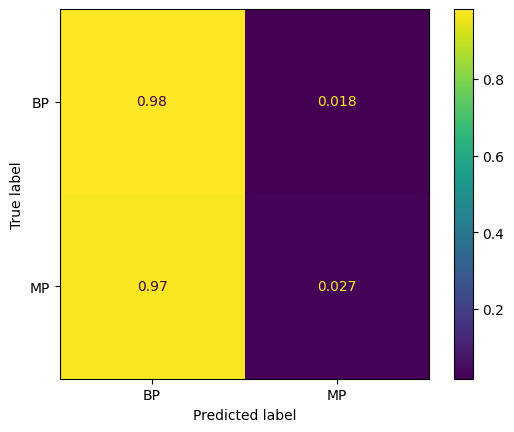

In [154]:
from sklearn.ensemble import RandomForestClassifier
model= RandomForestClassifier(max_depth=247, random_state=0)
EvalueteModel(model=model).plot()

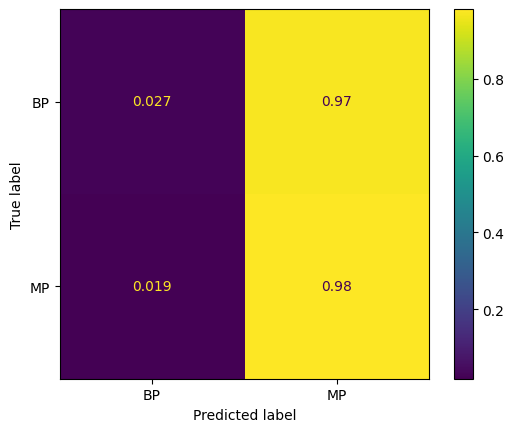

In [133]:
from sklearn.naive_bayes import GaussianNB
model=GaussianNB()   
EvalueteModel(model,X_train_OutliersTreatment,y_train_OutliersTreatment).plot()


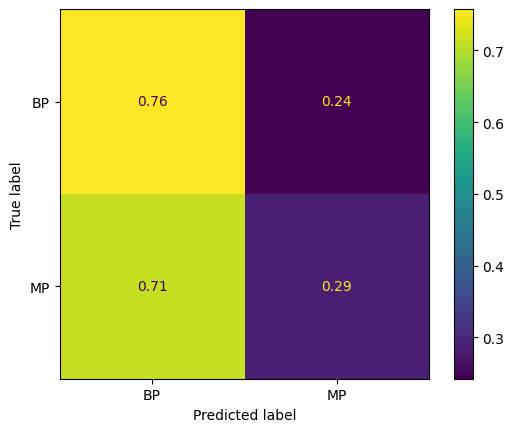

In [136]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(learning_rate=0.5, max_depth=100, n_estimators=10)

EvalueteModel(model,X_train_OutliersTreatment,y_train_OutliersTreatment).plot()


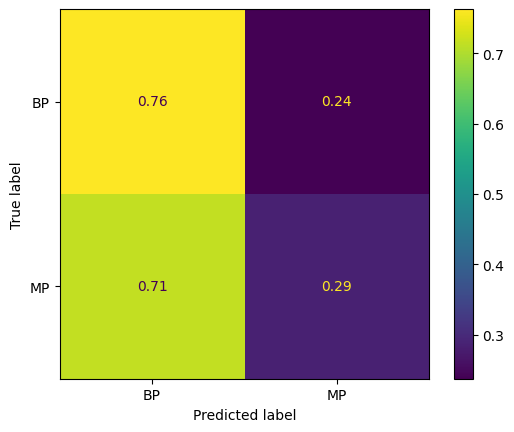

In [137]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(learning_rate=0.5, max_depth=100, n_estimators=40)

EvalueteModel(model,X_train_OutliersTreatment,y_train_OutliersTreatment).plot()


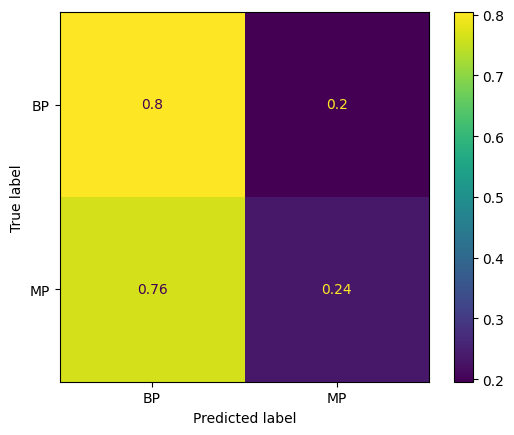

In [135]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(learning_rate=0.5, max_depth=50, n_estimators=10)
EvalueteModel(model,X_train_OutliersTreatment,y_train_OutliersTreatment).plot()


## Conclusão
Apesar de termos uma melhora considerável no recall de Mal Pagadores tivemos um queda considerável no recall de bons pagadores de 88% para 80%

# Testando modelos com oversampler

In [144]:
from imblearn.over_sampling import RandomOverSampler

r=RandomOverSampler(sampling_strategy=1)
x_r,y_r=r.fit_resample(X_train_OutliersTreatment,y_train_OutliersTreatment)

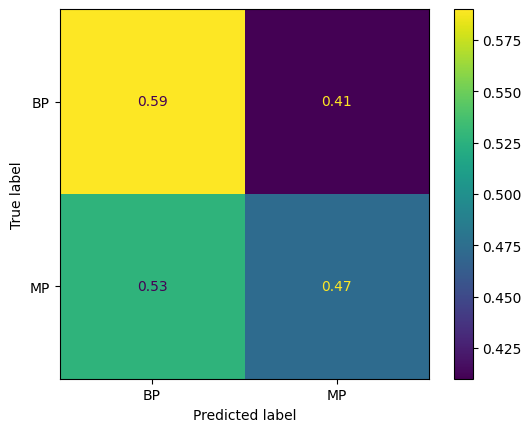

In [146]:
from sklearn.ensemble import GradientBoostingClassifier
# model = GradientBoostingClassifier(learning_rate=0.5, max_depth=100, n_estimators=40)
model = KNeighborsClassifier(n_neighbors=k)
EvalueteModel(model,x_r,y_r).plot()


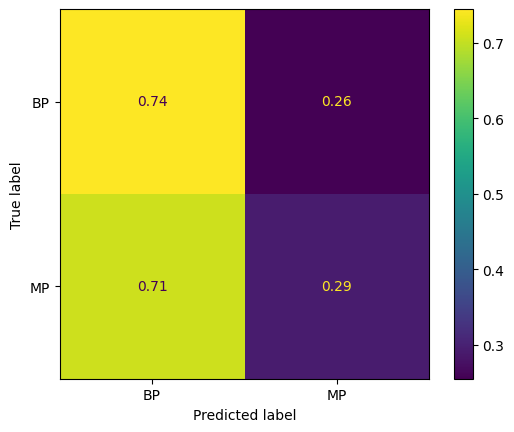

In [145]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(learning_rate=0.5, max_depth=100, n_estimators=40)

EvalueteModel(model,x_r,y_r).plot()

# Conclusão 
Nenhum modelo superior o KNN Classifier

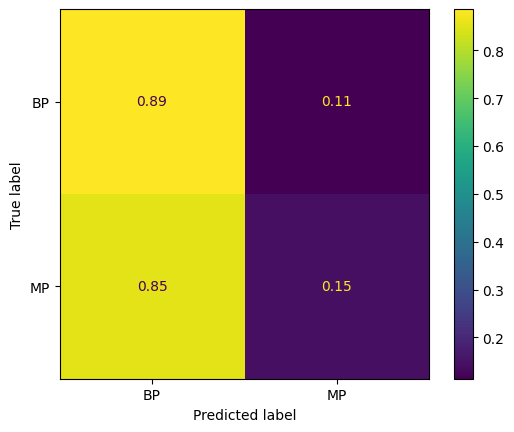

In [157]:
aval_dict['5 - Outlier Treatment: QUANT_DEPENDENTES'].plot()